# Import libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#Author: Sanjay Kottapalli, Dana Pe'er lab (kottapas@mskcc.org)

import numpy as np
import numpy.matlib
import pandas as pd
import scanpy as sc
from scanpy.external.pp import magic
import scipy
from sklearn.metrics import adjusted_rand_score
from scipy.stats.mstats import zscore
from scipy.stats import pearsonr
import csv
import os
import matplotlib
matplotlib.use('TkAgg')
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from copy import deepcopy
import timeit
from joblib import Parallel, delayed
from collections import Counter
np.random.seed(0)

# Define functions

In [3]:
def import_seqc_data(sample_name, path, dense=True):
    print('\nsample: ' + sample_name)
    if dense:
        PATH_TO_COUNT_CSV = path + sample_name + '_dense.csv'
        # import csv
        raw_counts = pd.read_csv(PATH_TO_COUNT_CSV, index_col=0, header=0)
        print(raw_counts.shape)
        #
        with open(PATH_TO_COUNT_CSV, "r") as f:
            reader = csv.reader(f)
            original_column_names = next(reader)
        # remove the first entry of this list, it belongs to the index column
        gene_names = original_column_names[1:]
        # and label the index column with name 'cell_barcodes'
        raw_counts.index.name = 'cell_barcodes'
        # convert indices to strings instead of integers for compatibility with scanpy
        raw_counts.index = raw_counts.index.astype(str)
        # python automatically converts duplicate column names to numbered column names,
        # e.g. 'X', 'X.1', 'X.2' etc. We can import the original column names from our CSV file:

        # now transpose the dataframe (for compatibility with panda's groupby function), 
        # then group by gene names, and add up the counts for genes with the same name
        raw_counts_transposed = raw_counts.T
        raw_counts_transposed_clean = raw_counts_transposed.groupby(gene_names, axis='index', sort=False).agg('sum')
        # transpose back
        raw_counts_clean = raw_counts_transposed_clean.T
        # if columns were added up, print how many:
        number_of_columns_removed = raw_counts.shape[1] - raw_counts_clean.shape[1]
        if number_of_columns_removed > 0:
            print(str(number_of_columns_removed) + ' columns were each merged with another column that had the same gene name.')
        # remove CLUSTER column:
        if 'CLUSTER' in raw_counts_clean.columns:
            raw_counts_clean.drop(columns='CLUSTER', inplace=True)
        # convert index type to string for compatibility with scanpy
        raw_counts_clean.index = raw_counts_clean.index.astype('str')
        adata = sc.AnnData(X = raw_counts_clean)
    else:
        barcodes = pd.read_csv(path+sample_name+'_sparse_counts_barcodes.csv', index_col=0, header=None)
        barcodes = barcodes[1].values
        barcodes = [str(i) for i in barcodes]
        gene_names = pd.read_csv(path+sample_name+'_sparse_counts_genes.csv', index_col=0, header=None)
        gene_names = gene_names[1].values
        sparse_counts = scipy.io.mmread(path+sample_name+'_sparse_molecule_counts.mtx').tocsc()
        #print("# of bytes: "+str(sparse_counts.data.nbytes))
        print(sparse_counts.shape)
        #sparse_counts = sparse_counts.toarray()#np.array(sparse_counts)
        #print(sparse_counts.shape)
        #raw_counts = pd.DataFrame.sparse.from_spmatrix(data=sparse_counts, index=barcodes, columns=gene_names)
        
        gene_dup = pd.Series(dict(Counter(gene_names)))
        gene_dup = gene_dup[gene_dup>1]
        #print(gene_dup)
        #print(len(set(gene_names)))
        gene_dup = list(gene_dup.keys())
        number_of_columns_removed = len(gene_dup)
        
        # sum of duplicate columns for each duplicate gene
        sum_dict = {i:sparse_counts[:,np.where(gene_names==i)[0]].sum(axis=1) for i in gene_dup}
        dup_index = []
        for i in gene_dup:
            dup_index += list(np.where(gene_names==i)[0])
        #print(sum_dict)
        #print(len(dup_index))
        #for i in sum_dict:
        #    print(sum_dict[i].sum(axis=0))
        
        #print(len(gene_names), sparse_counts.shape)
        keep_index = list(set(range(len(gene_names))) - set(dup_index))
        new_genes = list(gene_names[keep_index])
        new_counts = sparse_counts[:, keep_index]
        #print(len(new_genes), new_counts.shape)
        #print(new_counts.shape, type(new_counts))
        for i in sum_dict.keys():
            #print(sum_dict[i])
            #print(type(new_counts), type(sum_dict[i]))
            new_counts = scipy.sparse.hstack([new_counts, sum_dict[i]])
            new_genes.append(i)
        #print(len(new_genes), new_counts.shape)
        new_counts = new_counts.tocsc()
        print(new_counts.shape)#, type(new_counts))
        
        adata = sc.AnnData(X = new_counts, obs=pd.DataFrame(index=barcodes), var=pd.DataFrame(index=new_genes))
        
        if number_of_columns_removed > 0:
            print(str(number_of_columns_removed) + ' columns were each merged with another column that had the same gene name.')
       # take the min libsize in the dense cells, and 
        
        adata, mito_genes, RB_genes_in_data = qc_metrics(adata)
        # remove high mito frac cells
        cutoff = 20.0
        mito_val = adata.obs['pct_counts_mito']
        #print(mito_val)
        via_cells = mito_val[mito_val<cutoff]
        #print(via_cells)
        adata = adata[via_cells.index, :]
        print(adata.shape)
        
        PATH_TO_COUNT_CSV = path + sample_name + '_dense.csv'
        raw_counts = pd.read_csv(PATH_TO_COUNT_CSV, index_col=0, header=0)
        seqc_cells = [str(i) for i in raw_counts.index]
        libsize = adata.obs['original_total_counts'].sort_values(ascending=False)
        #pd.Series(index=adata.obs.index, data=np.array(np.sum(adata.X, axis=1).flatten())[0], dtype=str).sort_values(ascending=False)
        
        #difference = set(seqc_cells)-set([str(i) for i in libsize.iloc[:len(seqc_cells)+15000].index])
        #print(len(seqc_cells),len(difference))
        #print(seqc_cells[:20])
        #print(libsize.iloc[:20])
        
        adata = adata[libsize.iloc[:len(seqc_cells)+15000].index, :] # all dense cells + 15,000
        adata = sc.AnnData(X = adata.X, obs=pd.DataFrame(index=adata.obs.index), var=pd.DataFrame(index=adata.var.index))
        print(adata.shape)
        print("Cells filtered.")
    
    return adata

In [4]:
def qc_metrics(adata, path_RB=''):
    mito_genes = adata.var_names.str.startswith('MT-')
    adata.var['mito'] = mito_genes
    mito_genes = np.array(adata.var.index)[mito_genes]
    
    path_RB = path_RB+'RB_genes_human'
    with open(path_RB,'r') as file:
        lines = file.readlines()
    RB_genes = [x.rstrip('\n') for x in lines]
    data_genes = list(adata.var.index)
    RB_genes_in_data = set(data_genes).intersection(RB_genes)
    RB_genes_in_data = list(RB_genes_in_data)
    
    adata.var['ribo'] = False
    adata.var.loc[RB_genes_in_data, 'ribo'] = True
    
    sc.pp.calculate_qc_metrics(adata, qc_vars=('mito', 'ribo'), inplace=True)
    adata.obs['original_total_counts'] = adata.obs['total_counts']
    adata.obs['log10_original_total_counts'] = np.log10(adata.obs['original_total_counts'])
    print('QC metrics calculated.')
    
    return adata, mito_genes, RB_genes_in_data

In [5]:
def norm_filter(adata, mito_genes, RB_genes_in_data
                , log=True, remove_ribo=True, remove_mito=True, highly_var=False, markers=[]):
    
    adata.layers['raw_counts'] = adata.X
    # filter genes expressed in few cells
    print(adata.shape)
    sc.pp.filter_genes(adata, min_cells = 10)
    print(adata.shape)
    
    # libsize normalize
    if type(adata.X)==np.ndarray:
        med_libsize = np.median(np.sum(adata.X, axis=1))
    else:
        sums = np.array(np.sum(adata.X, axis=1).flatten())[0]
        #med_libsize = np.median(sums)
        if min(sums) == 0:
            empty_cells = set(np.where(sums==0)[0])
            print('# of 0-count droplets: '+str(len(empty_cells)))
            all_cells = set(adata.obs.index)
            keep_cells = all_cells-empty_cells
            adata = adata[keep_cells, :]
            sums = np.array(np.sum(adata.X, axis=1).flatten())[0]
        med_libsize = np.median(sums)

        print('Median library size: ' + str(med_libsize))

    sc.pp.normalize_total(adata)

    # log transform
    if log:
        adata.X = np.log2(adata.X+0.1) - np.log2(0.1)

        for i in deepcopy(markers):
            try:
                adata.obs[i+'_exp'] = adata[:,i].X
            except:
                markers.remove(i)
                print(i)

    else:
        for i in deepcopy(markers):
            try:
                adata.obs[i+'_exp'] = np.log2(adata[:,i].X+0.1)
            except:
                markers.remove(i)
                print(i)

    # remove ribosomal genes
    if remove_ribo:
        RB_genes_in_data.append('MALAT1')
        adata = adata[:,[x not in RB_genes_in_data for x in adata.var.index]]
        print(adata.shape)

    # remove mitochondrial genes
    if remove_mito:
        adata = adata[:,[x not in mito_genes for x in adata.var.index]]
        print(adata.shape)

    # highly variable gene selection
    print(highly_var)
    if highly_var:
        if not log:
            print('Im here1')
            sc.pp.highly_variable_genes(adata, layer='raw_counts', flavor='seurat_v3',max_mean=np.inf, n_top_genes=2000)#, batch_key='Sample ID')
            print(sum(adata.var['highly_variable']))
            adata.var.loc[markers, 'highly_variable'] = True
            print(sum(adata.var['highly_variable']))
            print(adata.shape)
        elif log:
            print('Im here2')
            sc.pp.highly_variable_genes(adata, layer=None, flavor='cell_ranger', max_mean=np.inf, n_top_genes=2000)#, batch_key='Sample ID')
            print(sum(adata.var['highly_variable']))
            adata.var.loc[markers, 'highly_variable'] = True
            print(sum(adata.var['highly_variable']))

    return adata, markers#adata_unlog, markers

In [6]:
def plot_pca(adata):
    #print("I am in here 1")
    
    print(adata.X)
    try:
        print(adata.shape)
        N = 1000
        adata_new = sc.tl.pca(adata, n_comps=N, copy = True)
    except:
        print(adata.shape) 
        N = min(adata.shape) - 1
        adata_new = sc.tl.pca(adata, n_comps=N, copy = True)
    
    #Plot variance explained
    x = range(len(adata_new.uns['pca']['variance_ratio']))
    y = adata_new.uns['pca']['variance_ratio']
    plt.scatter(x,y,s=4)
    plt.xlabel('PC')
    plt.ylabel('Fraction of variance explained')
    plt.title('Fraction of variance explained per PC')
    plt.show()
    
    #Plot cumulative variance
    cml_var_explained = np.cumsum(adata_new.uns['pca']['variance_ratio'])
    x = range(len(adata_new.uns['pca']['variance_ratio']))
    y = cml_var_explained
    plt.scatter(x,y,s=4)
    plt.xlabel('PC')
    plt.ylabel('Cumulative fraction of variance explained')
    plt.title('Cumulative fraction of variance explained by PCs')
    plt.show()
    
    return cml_var_explained, adata_new.uns['pca']['variance_ratio']
    
def kneepoint(vec):
    #print("I am in here 4")
    curve =  [1-x for x in vec]
    nPoints = len(curve)
    allCoord = np.vstack((range(nPoints), curve)).T
    np.array([range(nPoints), curve])
    firstPoint = allCoord[0]
    lineVec = allCoord[-1] - allCoord[0]
    lineVecNorm = lineVec / np.sqrt(np.sum(lineVec**2))
    vecFromFirst = allCoord - firstPoint
    scalarProduct = np.sum(vecFromFirst * numpy.matlib.repmat(lineVecNorm, nPoints, 1), axis=1)
    vecFromFirstParallel = np.outer(scalarProduct, lineVecNorm)
    vecToLine = vecFromFirst - vecFromFirstParallel
    distToLine = np.sqrt(np.sum(vecToLine ** 2, axis=1))
    idxOfBestPoint = np.argmax(distToLine)
    
    return idxOfBestPoint
    
def run_pca_knee(adata):
    cml, var = plot_pca(adata)

    knee = kneepoint(var)
    
    print("Knee point: "+str(knee))
    print("Explained variance: " + str(cml[knee]))

    x=list(range(len(cml)))
    plt.plot(x[:5*knee],cml[:5*knee])
    plt.show()

    adata_new = sc.tl.pca(adata, n_comps=knee+1, copy=True)
    sc.pl.pca_loadings(adata_new, components=range(1,4))
    
    return adata_new

In [7]:
def files_MAST(adata, cell_type = '', outdir = ''):
    
    # if directory doesn't exist, create it
    if not os.path.exists('DEA/' + cell_type):
        os.makedirs('DEA/' + cell_type)
    
    adata_celltype = deepcopy(adata)
    #adata_celltype = adata_celltype[adata_celltype.obs['final_subclusters'].isin([cell_type]),:]
    print(cell_type + '\t'+"Dimensions" + "\t"+ "{}".format(adata_celltype.shape))
    
    # make a dataframe for the expression matrix
    expmat = pd.DataFrame(adata_celltype.X, columns = adata_celltype.var.index, index = adata_celltype.obs.index)

    # make a dataframe for the observation data
    cdata = pd.DataFrame(adata_celltype.obs, columns=adata_celltype.obs.columns, index = adata_celltype.obs.index)

    
    expmat.to_csv(r'DEA/'+ cell_type + '/adata_'+ cell_type+ '_exp_mat.csv', index=True)
    cdata.to_csv(r'DEA/'+ cell_type + '/adata_'+ cell_type+ '_cdata.csv', index=True)
    
    print("Files written for {}".format(cell_type))

In [8]:
def run_MAST_for_celltype(adata, cell_type):
    start_time = timeit.default_timer()
    MAST = './runMAST.R'
    
    # run 
    files_MAST(adata = adata, cell_type = cell_type)
    
    expmat_Inputfile = ('DEA/'+ cell_type + '/adata_'+ cell_type+ '_exp_mat.csv')
    cdata_Inputfile = ('DEA/'+ cell_type + '/adata_'+ cell_type+ '_cdata.csv')
    output_file_cort = 'DEA/' +  cell_type + "/MAST_DEA_" + cell_type + "_cort.csv" 
    output_file_bs = 'DEA/' +  cell_type + "/MAST_DEA_" + cell_type + "_bs.csv" 
    
    print("Running " + MAST + " " + expmat_Inputfile + " " + cdata_Inputfile + " " + output_file_cort + " " + output_file_bs)
    
    os.system(MAST + " " + expmat_Inputfile + " " + cdata_Inputfile + " " + output_file_cort + " " + output_file_bs)
    out_str = "Finished running MAST on"+ "( " + cell_type +  ")" +" in {} seconds.".format(timeit.default_timer()-start_time)
    
    return out_str

In [9]:
godsnot_64 = [
    # "#000000",  # remove the black, as often, we have black colored annotation
    "#d9d929", "#1CE6FF", "#FF34FF", "#FF4A46", "#008941", "#006FA6", "#A30059",
    "#FFDBE5", "#7A4900", "#0000A6", "#63FFAC", "#B79762", "#004D43", "#8FB0FF", "#997D87",
    "#5A0007", "#809693", "#6A3A4C", "#1B4400", "#4FC601", "#3B5DFF", "#4A3B53", "#FF2F80",
    "#61615A", "#BA0900", "#6B7900", "#00C2A0", "#FFAA92", "#FF90C9", "#B903AA", "#D16100",
    "#DDEFFF", "#000035", "#7B4F4B", "#A1C299", "#300018", "#0AA6D8", "#013349", "#00846F",
    "#372101", "#FFB500", "#C2FFED", "#A079BF", "#CC0744", "#C0B9B2", "#C2FF99", "#001E09",
    "#00489C", "#6F0062", "#0CBD66", "#EEC3FF", "#456D75", "#B77B68", "#7A87A1", "#788D66",
    "#885578", "#FAD09F", "#FF8A9A", "#D157A0", "#BEC459", "#456648", "#0086ED", "#886F4C",
    "#34362D", "#B4A8BD", "#00A6AA", "#452C2C", "#636375", "#A3C8C9", "#FF913F", "#938A81",
    "#575329", "#00FECF", "#B05B6F", "#8CD0FF", "#3B9700", "#04F757", "#C8A1A1", "#1E6E00",
    "#7900D7", "#A77500", "#6367A9", "#A05837", "#6B002C", "#772600", "#D790FF", "#9B9700",
    "#549E79", "#FFF69F", "#201625", "#72418F", "#BC23FF", "#99ADC0", "#3A2465", "#922329",
    "#5B4534", "#FDE8DC", "#404E55", "#0089A3", "#CB7E98", "#A4E804", "#324E72"]

# Populate input parameters

In [10]:
# populate from command line
samples = ['1819_C1029_Ctrl_ES_Cort_IGO_10837_23', '1820_C1029_Ctrl_ES_BS_IGO_10856_3', '1821_996_VE_ES_Cort_IGO_10875_6', '1822_996_VE_ES_BS_IGO_10875_7']
indir = '../input/'
outdir = '../output_Nov/'
figures = '../figures/'

In [11]:
adata_oligo = sc.read_h5ad(outdir+'adata_high_var_Oligo_diff_norm_clusters.h5ad')

## Oligo Brainstem

In [12]:
adata_oligo_BS = adata_oligo.copy()
adata_oligo_BS = adata_oligo_BS[adata_oligo_BS.obs['B_region'].isin(['BrainStem']),:]
adata_oligo_BS.shape

/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


(4132, 13466)

In [13]:
adata_oligo_BS.obs.Condition.value_counts()

VE         2752
Control    1380
Name: Condition, dtype: int64

In [20]:
broad_clusters = adata_oligo_BS.obs['Condition']
unique_clusters = np.unique(broad_clusters.values)
samples = adata_oligo_BS.obs['Sample ID']
print('Cell counts in each cluster for each sample: ')

for cluster in unique_clusters:
    print('Cluster: '+str(cluster))
    index = broad_clusters[broad_clusters==cluster].index
    count = Counter(samples[index].values)
    print(count)

Cell counts in each cluster for each sample: 
Cluster: Control
Counter({'1820_C1029_Ctrl_ES_BS_IGO_10856_3': 1380})
Cluster: VE
Counter({'1822_996_VE_ES_BS_IGO_10875_7': 2752})


In [21]:
path_to_h5ad_file = outdir+'adata.h5ad'
adata = sc.read_h5ad(path_to_h5ad_file)
print(adata)
# Add a new column describing the sample condition
adata.obs['Condition'] = np.where(adata.obs['Sample ID'] == '1819_C1029_Ctrl_ES_Cort_IGO_10837_23', "Control", "NA")
adata.obs['Condition'] = np.where(adata.obs['Sample ID'] == '1820_C1029_Ctrl_ES_BS_IGO_10856_3', "Control", adata.obs['Condition'])
adata.obs['Condition'] = np.where(adata.obs['Sample ID'] == '1821_996_VE_ES_Cort_IGO_10875_6', "VE", adata.obs['Condition'])
adata.obs['Condition'] = np.where(adata.obs['Sample ID'] == '1822_996_VE_ES_BS_IGO_10875_7', "VE", adata.obs['Condition'])


adata.obs.head()

AnnData object with n_obs × n_vars = 26101 × 22292
    obs: 'Sample ID'


Sample ID  \
cell_barcodes                                                                              
120703436570020_1819_C1029_Ctrl_ES_Cort_IGO_108...  1819_C1029_Ctrl_ES_Cort_IGO_10837_23   
120703455227244_1819_C1029_Ctrl_ES_Cort_IGO_108...  1819_C1029_Ctrl_ES_Cort_IGO_10837_23   
120703455251884_1819_C1029_Ctrl_ES_Cort_IGO_108...  1819_C1029_Ctrl_ES_Cort_IGO_10837_23   
120703455704877_1819_C1029_Ctrl_ES_Cort_IGO_108...  1819_C1029_Ctrl_ES_Cort_IGO_10837_23   
120718441244516_1819_C1029_Ctrl_ES_Cort_IGO_108...  1819_C1029_Ctrl_ES_Cort_IGO_10837_23   

                                                   Condition  
cell_barcodes                                                 
120703436570020_1819_C1029_Ctrl_ES_Cort_IGO_108...   Control  
120703455227244_1819_C1029_Ctrl_ES_Cort_IGO_108...   Control  
120703455251884_1819_C1029_Ctrl_ES_Cort_IGO_108...   Control  
120703455704877_1819_C1029_Ctrl_ES_Cort_IGO_108...   Control  
120718441244516_1819_C1029_Ctrl_ES_Cort_IGO_108...   Control

In [22]:
# Add a new column describing the sample condition
adata.obs['B_region'] = np.where(adata.obs['Sample ID'] == '1819_C1029_Ctrl_ES_Cort_IGO_10837_23', "Cortex", "NA")
adata.obs['B_region'] = np.where(adata.obs['Sample ID'] == '1820_C1029_Ctrl_ES_BS_IGO_10856_3', "BrainStem", adata.obs['B_region'])
adata.obs['B_region'] = np.where(adata.obs['Sample ID'] == '1821_996_VE_ES_Cort_IGO_10875_6', "Cortex", adata.obs['B_region'])
adata.obs['B_region'] = np.where(adata.obs['Sample ID'] == '1822_996_VE_ES_BS_IGO_10875_7', "BrainStem", adata.obs['B_region'])


#adata.obs
# count the number of NAs
sum(pd.isna(adata.obs['B_region']))

0

In [23]:
adata_oligo_BS = adata[adata_oligo_BS.obs.index, :]
adata_oligo_BS.shape

/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


(4132, 22292)

## QC

In [25]:
adata_oligo_BS, mito_genes, RB_genes_in_data = qc_metrics(adata_oligo_BS)
markers = []
if type(adata_oligo_BS.X)==np.ndarray:
    pass
else:
    print(type(adata_oligo_BS.X))
    #print(adata_norm.X.shape)
    adata_oligo_BS.X = adata_oligo_BS.X.toarray()
    #print(adata_norm.X.shape)
adata_oligo_BS.X = pd.DataFrame(data=adata_oligo_BS.X).fillna(0).values

QC metrics calculated.
<class 'scipy.sparse.csr.csr_matrix'>


In [26]:
adata_oligo_BS.shape

(4132, 22292)

## Normalization

In [27]:
markers = []
adata_oligo_BS, markers = norm_filter(adata_oligo_BS, mito_genes, RB_genes_in_data, markers=[], highly_var=True)
adata_oligo_BS.obs.head()

(4132, 22292)


/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


(4132, 13377)
(4132, 13199)
(4132, 13186)
True
Im here2


Trying to set attribute `.uns` of view, copying.


2000
2000


Sample ID  \
cell_barcodes                                                                          
126682808839406_1822_996_VE_ES_BS_IGO_10875_7          1822_996_VE_ES_BS_IGO_10875_7   
133837016655653_1820_C1029_Ctrl_ES_BS_IGO_10856_3  1820_C1029_Ctrl_ES_BS_IGO_10856_3   
160218196928869_1822_996_VE_ES_BS_IGO_10875_7          1822_996_VE_ES_BS_IGO_10875_7   
191215658986269_1820_C1029_Ctrl_ES_BS_IGO_10856_3  1820_C1029_Ctrl_ES_BS_IGO_10856_3   
126682836687156_1822_996_VE_ES_BS_IGO_10875_7          1822_996_VE_ES_BS_IGO_10875_7   

                                                  Condition   B_region  \
cell_barcodes                                                            
126682808839406_1822_996_VE_ES_BS_IGO_10875_7            VE  BrainStem   
133837016655653_1820_C1029_Ctrl_ES_BS_IGO_10856_3   Control  BrainStem   
160218196928869_1822_996_VE_ES_BS_IGO_10875_7            VE  BrainStem   
191215658986269_1820_C1029_Ctrl_ES_BS_IGO_10856_3   Control  BrainStem   
126682836687156_1822_996_VE_ES_BS_IGO_10875_7            VE  BrainStem   

                                                   n_genes_by_counts  \
cell_barcodes                                                          
126682808839406_1822_996_VE_ES_BS_IGO_10875_7                   1065   
133837016655653_1820_C1029_Ctrl_ES_BS_IGO_10856_3               2291   
160218196928869_1822_996_VE_ES_BS_IGO_10875_7                    976   
191215658986269_1820_C1029_Ctrl_ES_BS_IGO_10856_3                881   
126682836687156_1822_996_VE_ES_BS_IGO_10875_7                   1009   

                                                   log1p_n_genes_by_counts  \
cell_barcodes                                                                
126682808839406_1822_996_VE_ES_BS_IGO_10875_7                     6.971669   
133837016655653_1820_C1029_Ctrl_ES_BS_IGO_10856_3                 7.737180   
160218196928869_1822_996_VE_ES_BS_IGO_10875_7                     6.884487   
191215658986269_1820_C1029_Ctrl_ES_BS_IGO_10856_3                 6.782192   
126682836687156_1822_996_VE_ES_BS_IGO_10875_7                     6.917706   

                                                   total_counts  \
cell_barcodes                                                     
126682808839406_1822_996_VE_ES_BS_IGO_10875_7            1692.0   
133837016655653_1820_C1029_Ctrl_ES_BS_IGO_10856_3        4746.0   
160218196928869_1822_996_VE_ES_BS_IGO_10875_7            1559.0   
191215658986269_1820_C1029_Ctrl_ES_BS_IGO_10856_3        1457.0   
126682836687156_1822_996_VE_ES_BS_IGO_10875_7            1580.0   

                                                   log1p_total_counts  \
cell_barcodes                                                           
126682808839406_1822_996_VE_ES_BS_IGO_10875_7                7.434258   
133837016655653_1820_C1029_Ctrl_ES_BS_IGO_10856_3            8.465268   
160218196928869_1822_996_VE_ES_BS_IGO_10875_7                7.352441   
191215658986269_1820_C1029_Ctrl_ES_BS_IGO_10856_3            7.284821   
126682836687156_1822_996_VE_ES_BS_IGO_10875_7                7.365813   

                                                   pct_counts_in_top_50_genes  \
cell_barcodes                                                                   
126682808839406_1822_996_VE_ES_BS_IGO_10875_7                       22.044917   
133837016655653_1820_C1029_Ctrl_ES_BS_IGO_10856_3                   28.107880   
160218196928869_1822_996_VE_ES_BS_IGO_10875_7                       28.223220   
191215658986269_1820_C1029_Ctrl_ES_BS_IGO_10856_3                   28.826356   
126682836687156_1822_996_VE_ES_BS_IGO_10875_7                       24.683544   

                                                   pct_counts_in_top_100_genes  \
cell_barcodes                                                                    
126682808839406_1822_996_VE_ES_BS_IGO_10875_7                        31.560284   
133837016655653_1820_C1029_Ctrl_ES_BS_IGO_10856_3                    34.091867   
160218196

## PCA

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(4132, 13186)


/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


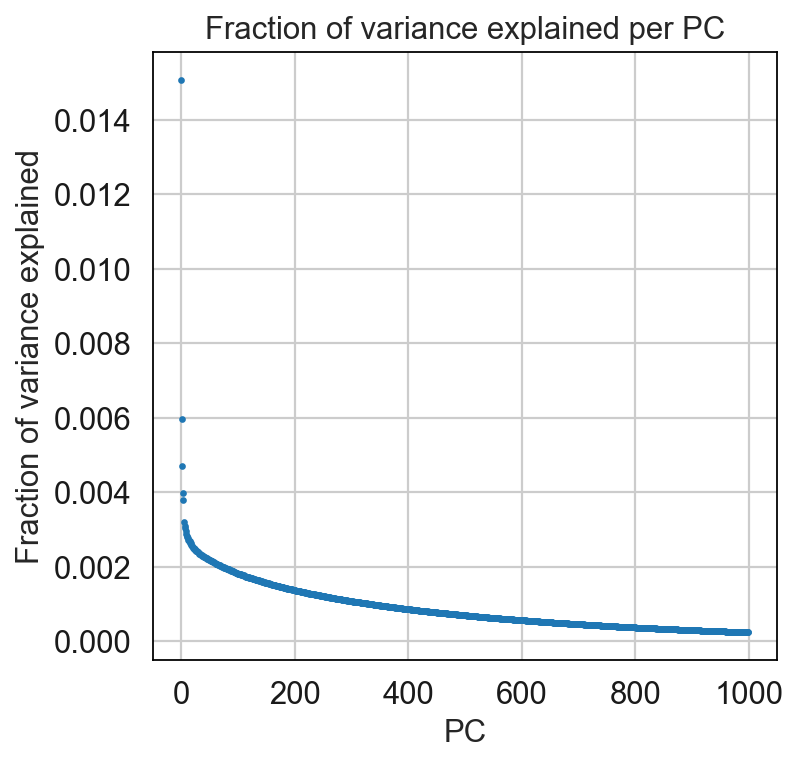

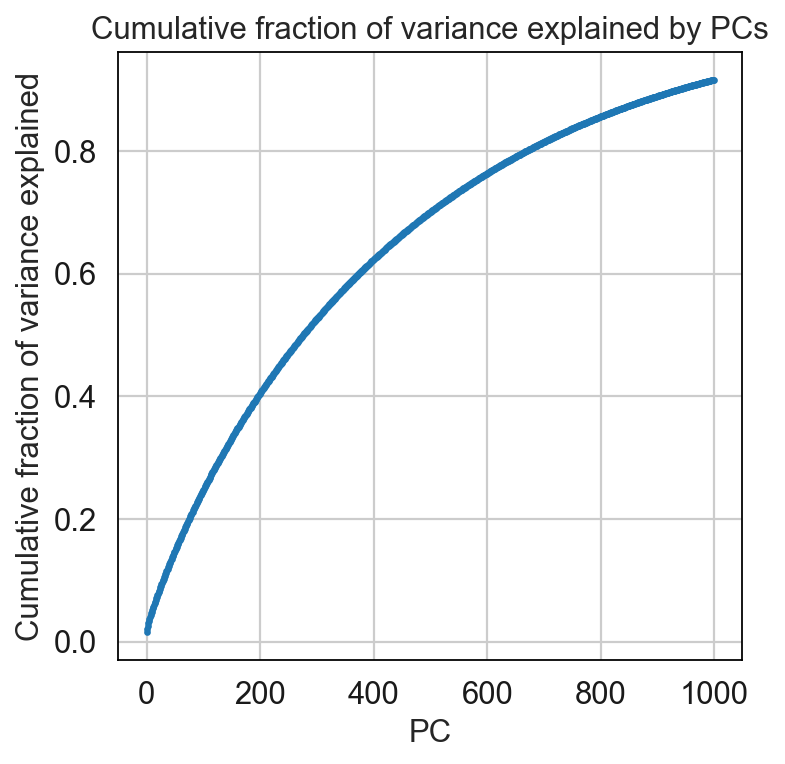

Knee point: 21
Explained variance: 0.08076464


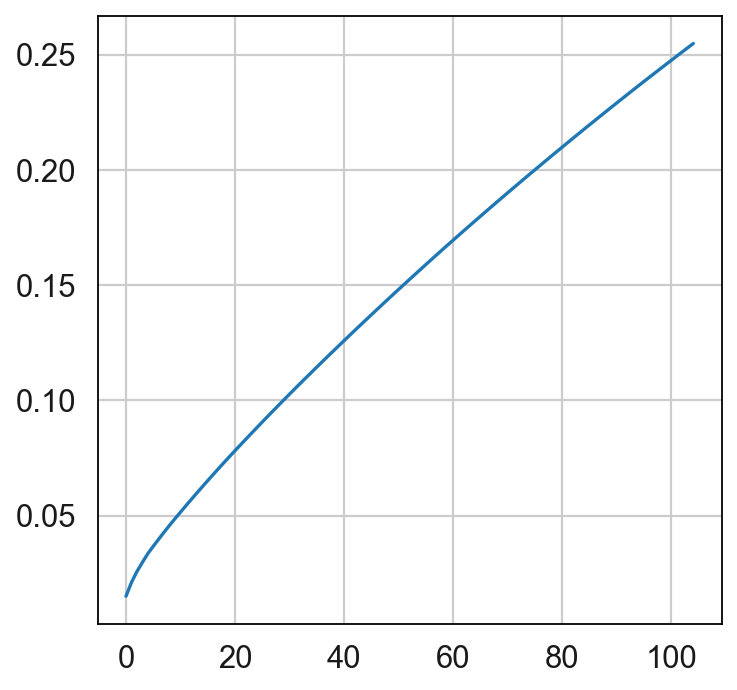

/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8942 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8942 missing from current font.
  font.set_text(s, 0, flags=flags)


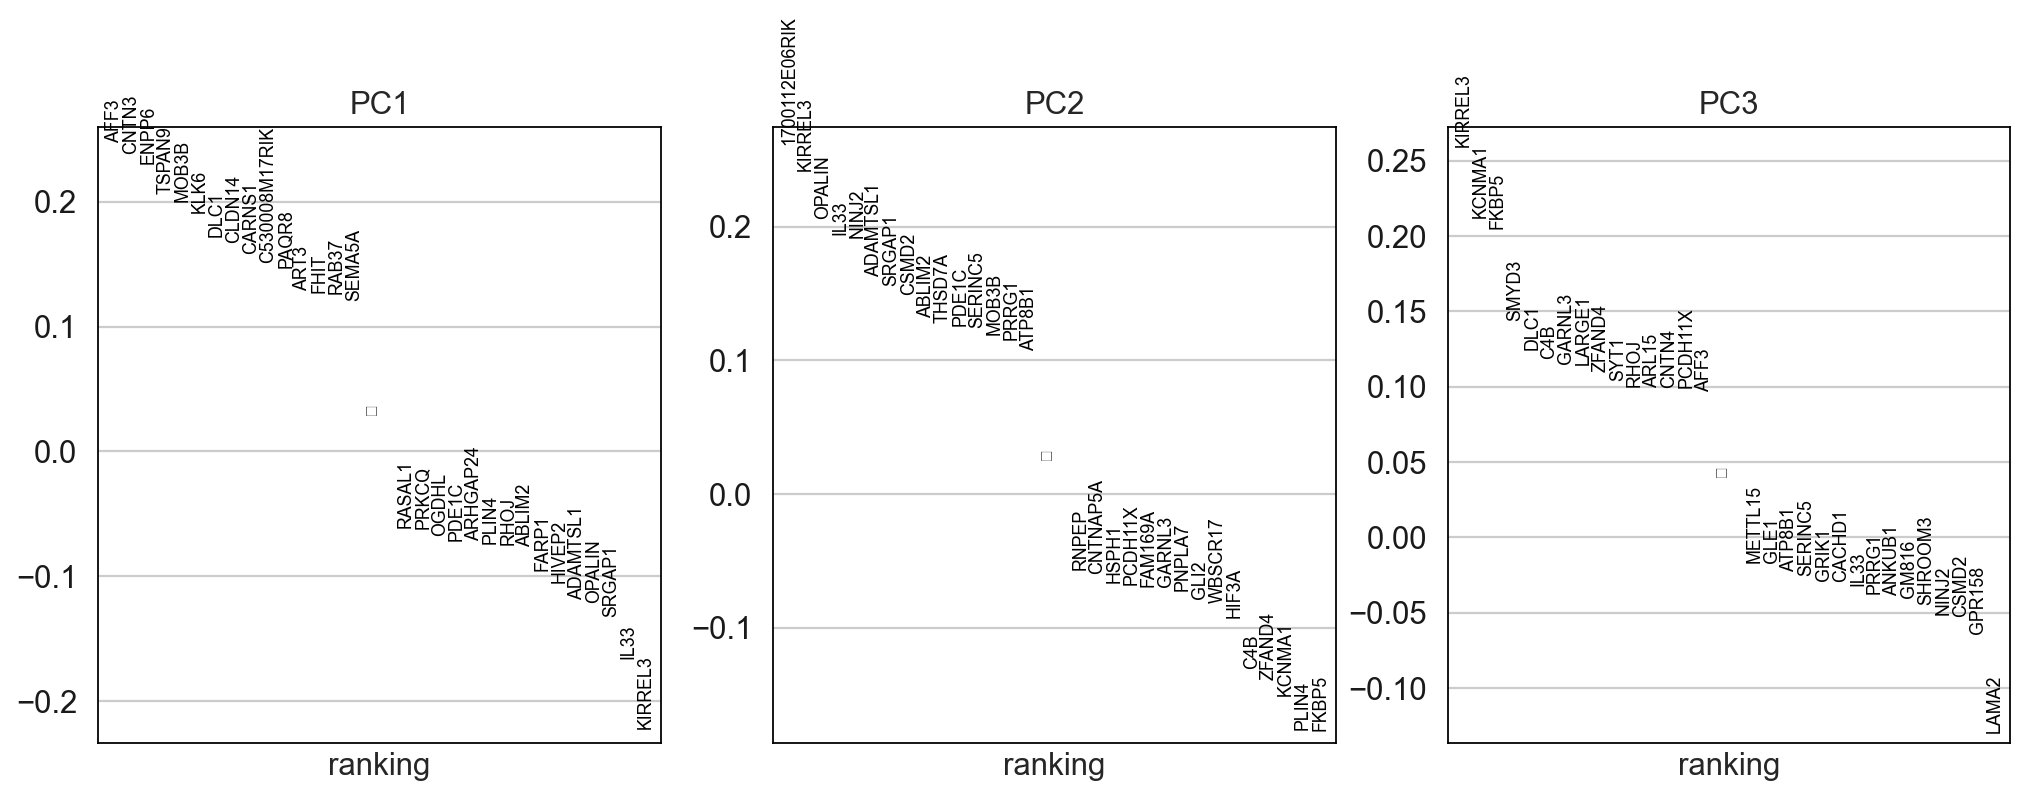

(4132, 13186)


/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [28]:
sc.set_figure_params(figsize=(5, 5))
adata_oligo_BS = run_pca_knee(adata_oligo_BS)#, 0.5)
adata_oligo_BS.obs['PC 1'] = adata_oligo_BS.obsm['X_pca'][:,0] # optional
adata_oligo_BS.obs['PC 2'] = adata_oligo_BS.obsm['X_pca'][:,1]
adata_oligo_BS.obs['PC 3'] = adata_oligo_BS.obsm['X_pca'][:,2]

print(adata_oligo_BS.shape)
adata_oligo_BS.X = pd.DataFrame(adata_oligo_BS.X).fillna(0).values
index_list = np.arange(adata_oligo_BS.shape[0])
np.random.shuffle(index_list)
adata_oligo_BS = adata_oligo_BS[index_list,:]

In [29]:
print(adata_oligo_BS.shape)
adata_oligo_BS.X = pd.DataFrame(adata_oligo_BS.X).fillna(0).values
index_list = np.arange(adata_oligo_BS.shape[0])
np.random.shuffle(index_list)
adata_oligo_BS = adata_oligo_BS[index_list,:]

(4132, 13186)


## Phenograph

Finding 10 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.3582642078399658 seconds
Jaccard graph constructed in 2.6073031425476074 seconds
Wrote graph to binary file in 0.04695606231689453 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.690993
After 11 runs, maximum modularity is Q = 0.692274
Louvain completed 31 runs in 1.3385169506072998 seconds
Sorting communities by size, please wait ...
PhenoGraph complete in 5.101434230804443 seconds


Trying to set attribute `.obs` of view, copying.


Finding 15 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.28433990478515625 seconds
Jaccard graph constructed in 0.8787081241607666 seconds
Wrote graph to binary file in 0.17152118682861328 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.623609
After 2 runs, maximum modularity is Q = 0.625546
After 10 runs, maximum modularity is Q = 0.626635
After 14 runs, maximum modularity is Q = 0.628792
After 23 runs, maximum modularity is Q = 0.630171
Louvain completed 43 runs in 2.5898830890655518 seconds
Sorting communities by size, please wait ...
PhenoGraph complete in 5.026609897613525 seconds
Finding 20 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.28790903091430664 seconds
Jaccard graph constructed in 0.9873249530792236 seconds
Wrote graph to binary file in 0.2345421314239502 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.595869


Text(0.5, 0, 'k')

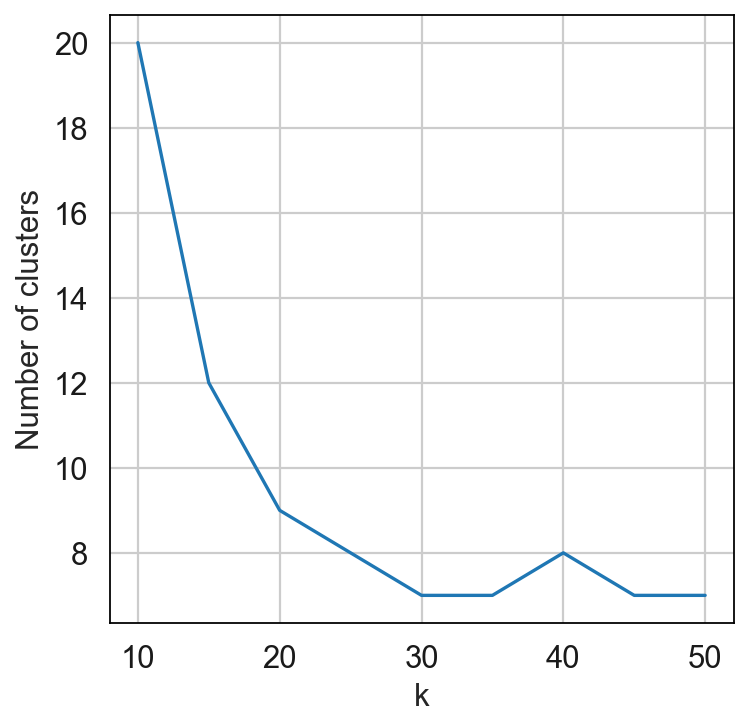

In [30]:
k_list = list(range(10, 55, 5))
n_clusters = []
for k in k_list:
    communities, graph, Q = sc.external.tl.phenograph(pd.DataFrame(adata_oligo_BS.obsm['X_pca']),k=k)
    n_clusters.append(len(np.unique(communities)))
    adata_oligo_BS.obs['PhenoGraph_clusters_oligo_BS'+str(k)] = pd.Categorical(communities)
    adata_oligo_BS.uns['PhenoGraph_Q_'+str(k)] = Q
    adata_oligo_BS.uns['PhenoGraph_k_'+str(k)] = k
plt.plot(k_list,n_clusters)
plt.ylabel("Number of clusters")
plt.xlabel("k")

In [31]:
Rand_index_df = pd.DataFrame(np.zeros((len(k_list), len(k_list))),index=k_list,columns=k_list)
Rand_index_df.index.name='k1'
Rand_index_df.columns.name='k2'
row_ind = 0
for run1 in range(len(k_list)):
    col_ind = 0
    for run2 in range(len(k_list)):
        Rand_index_df.iloc[row_ind,col_ind] = adjusted_rand_score(
            adata_oligo_BS.obs['PhenoGraph_clusters_oligo_BS'+str(k_list[run1])].values,
            adata_oligo_BS.obs['PhenoGraph_clusters_oligo_BS'+str(k_list[run2])].values)
        col_ind = col_ind+1
    row_ind = row_ind+1
    

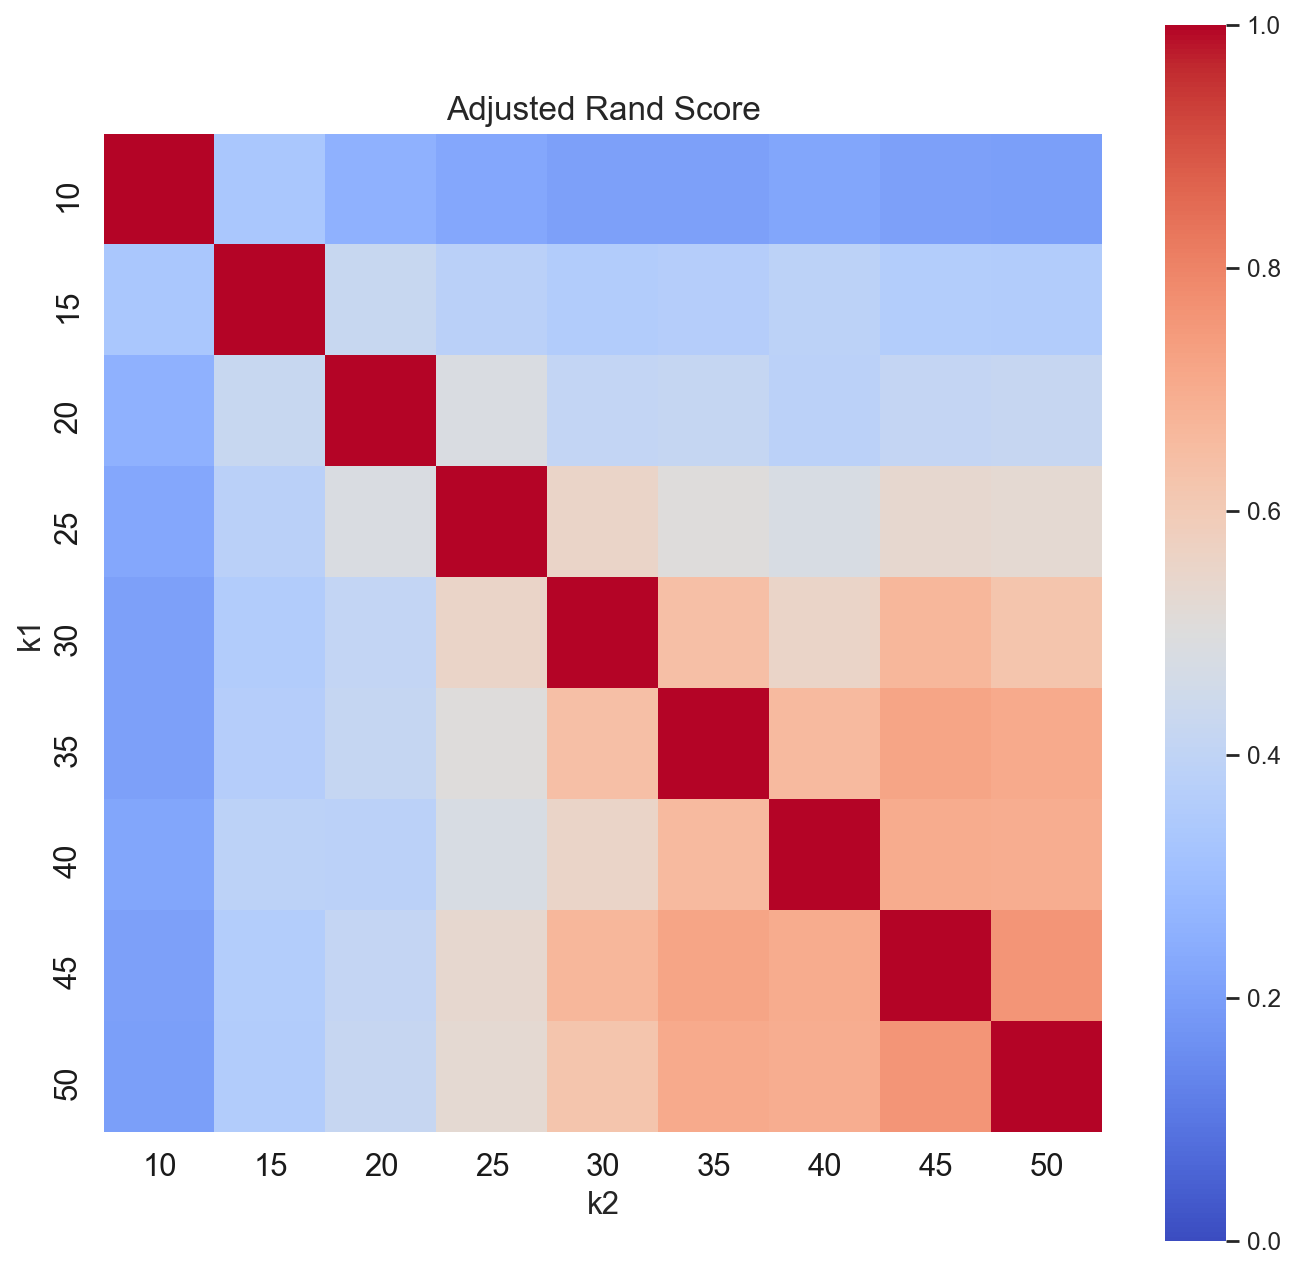

In [32]:
Rand_fig = plt.figure(figsize = (10,10))
plt.xlabel('k1')
plt.ylabel('k2')
plt.title('Adjusted Rand Score',fontsize=15)
sns.set(font_scale=1)
sns.heatmap(Rand_index_df, cmap=('coolwarm'), square=True, vmin=0, vmax=1)
# plt.colorbar(vmin=0)
plt.show();plt.close()


In [39]:
k = 45 # choose k
communities, graph, Q = sc.external.tl.phenograph(pd.DataFrame(adata_oligo_BS.obsm['X_pca']),k=k) # run PhenoGraph
adata_oligo_BS.obs['PhenoGraph_clusters_oligo_BS'] = pd.Categorical(communities)
adata_oligo_BS.uns['PhenoGraph_Q'] = Q
adata_oligo_BS.uns['PhenoGraph_k'] = k

Finding 45 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.28777027130126953 seconds
Jaccard graph constructed in 1.267082929611206 seconds
Wrote graph to binary file in 0.5534439086914062 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.553594
Louvain completed 21 runs in 2.054492950439453 seconds
Sorting communities by size, please wait ...
PhenoGraph complete in 4.8141210079193115 seconds


## Vizualize Oligo sub-clusters

In [40]:
sc.set_figure_params(figsize=(8, 8))
sc.pp.neighbors(adata_oligo_BS, method='umap', use_rep='X_pca')
sc.tl.umap(adata_oligo_BS, random_state=None)

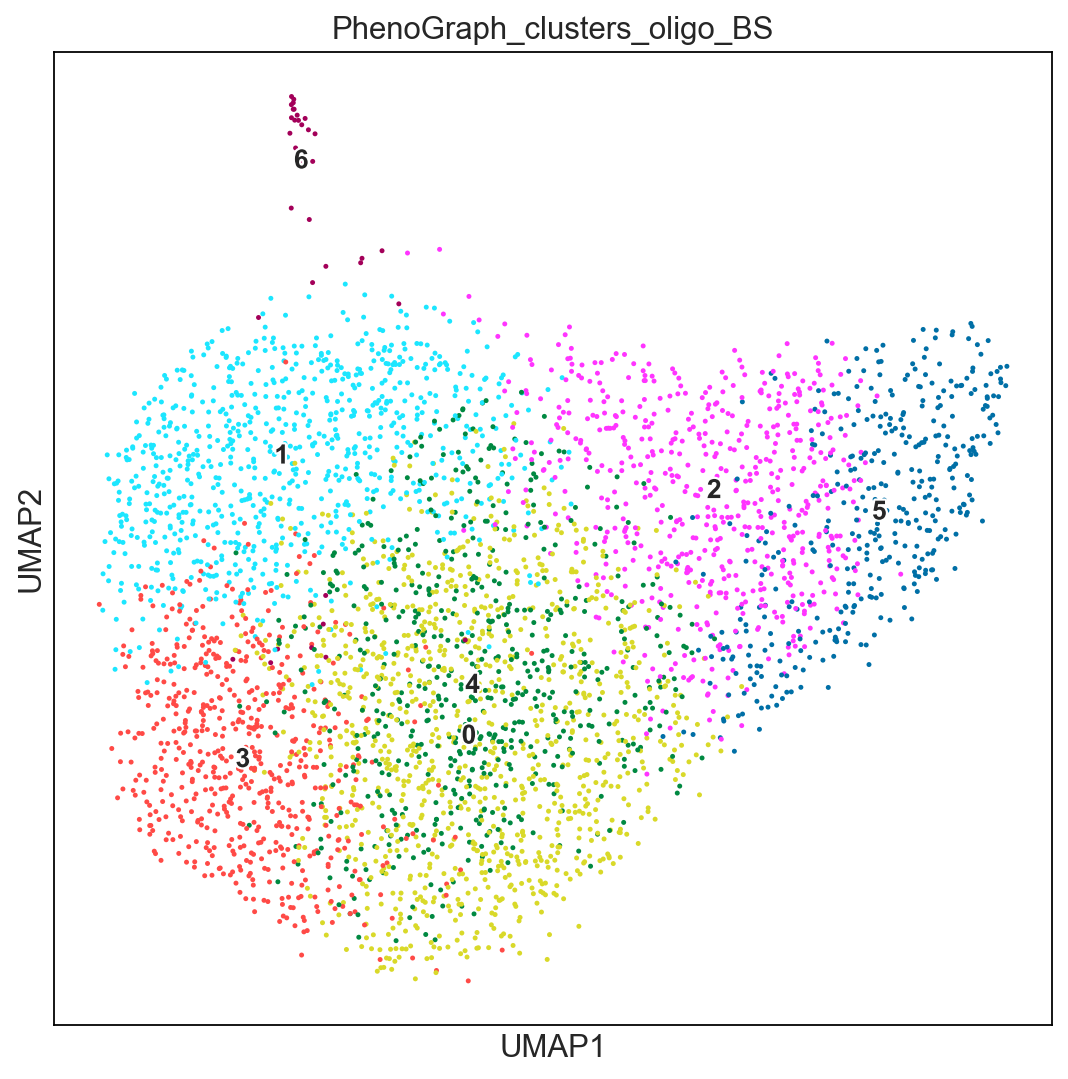

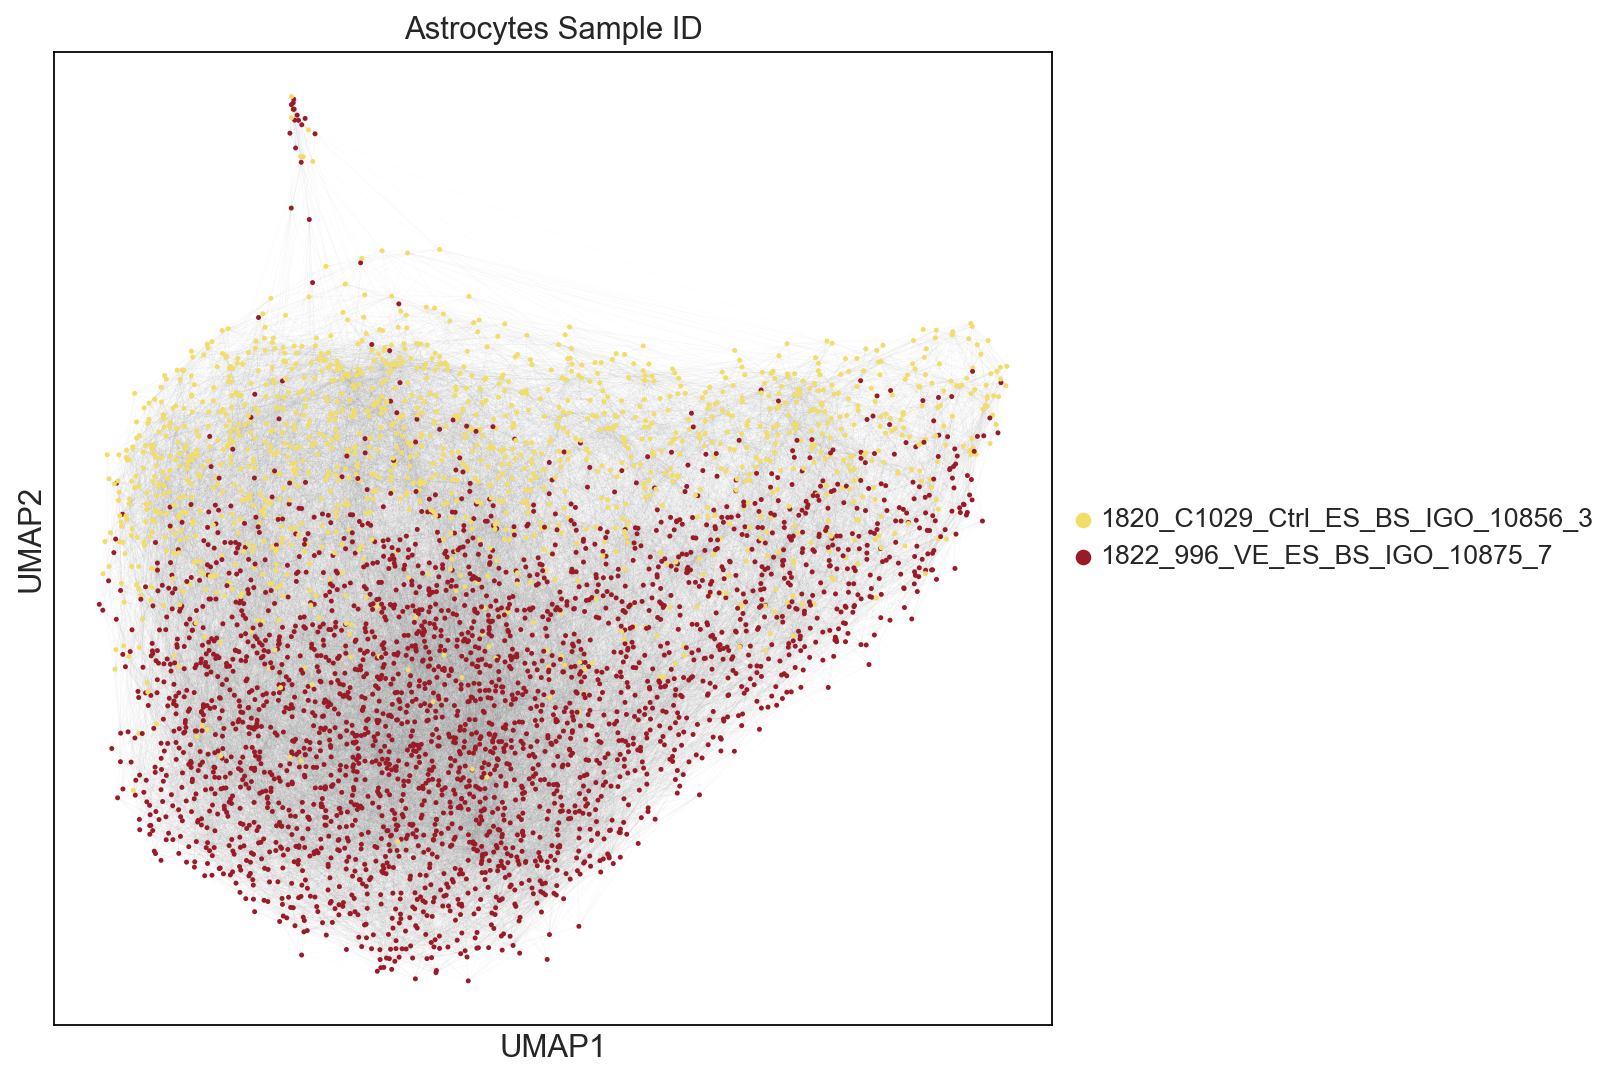

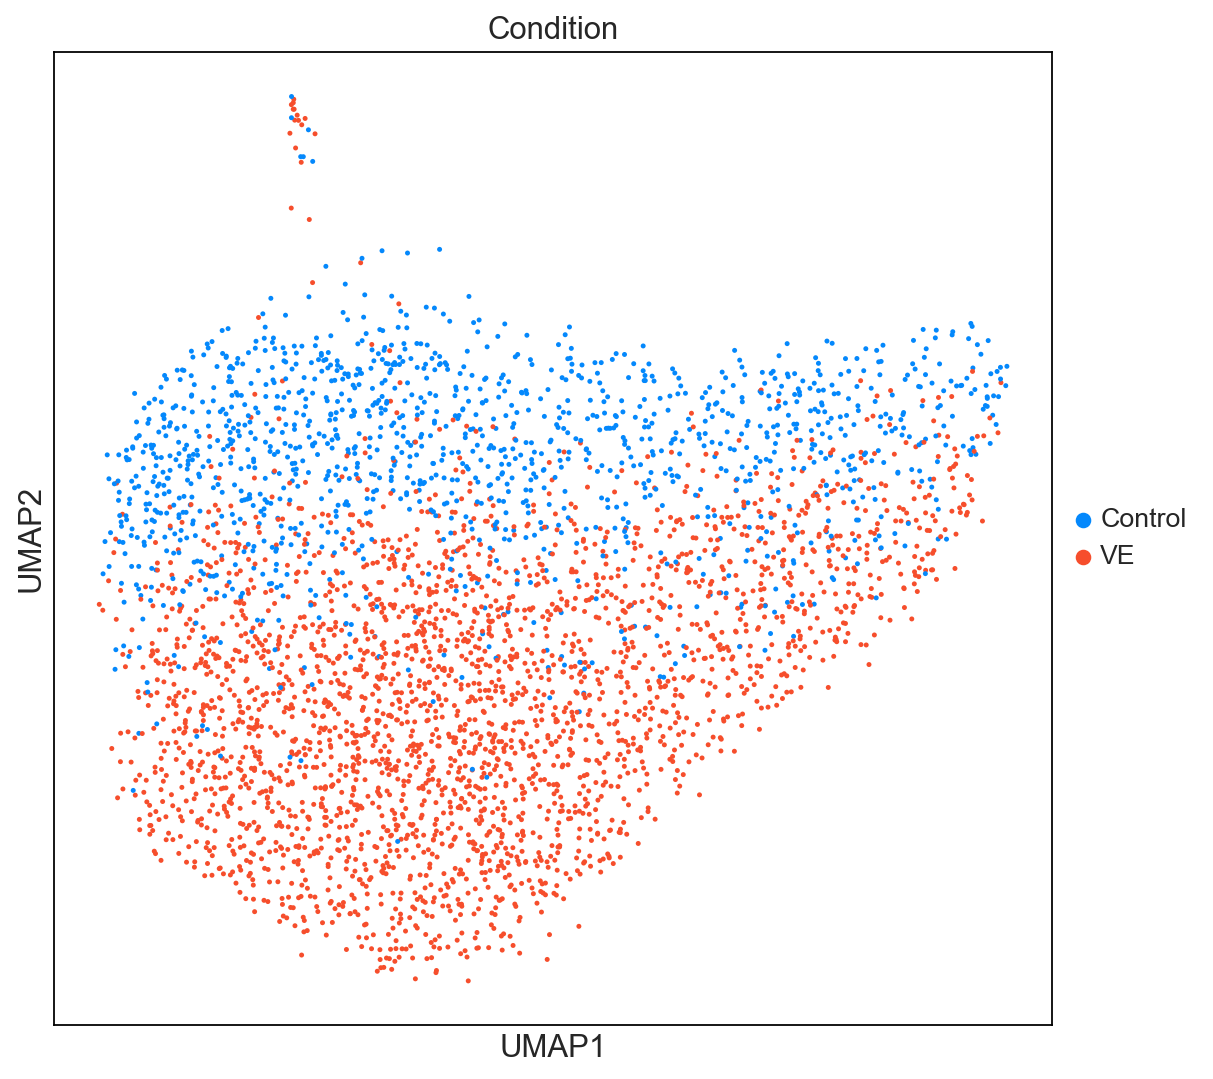

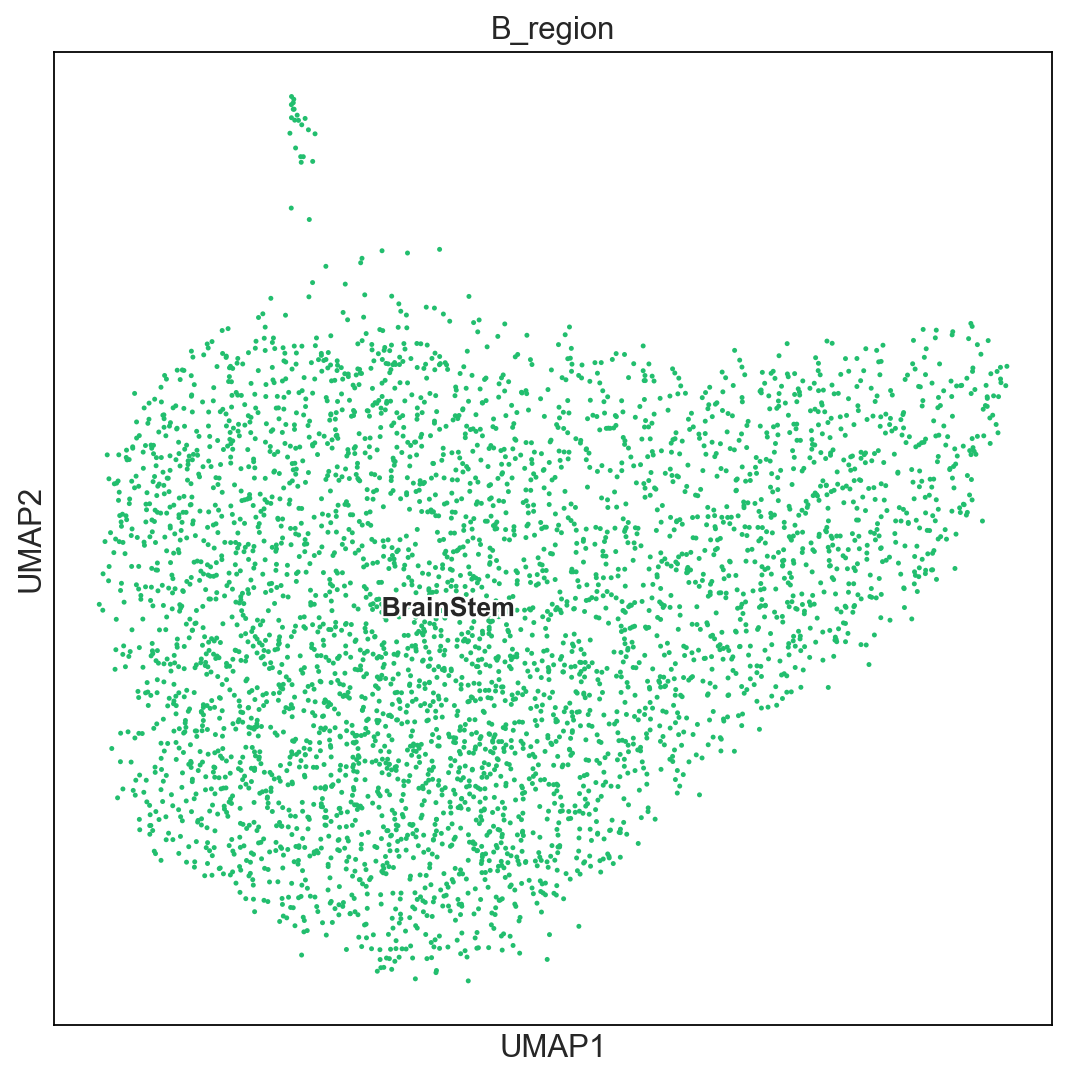

In [41]:
sc.pl.umap(adata_oligo_BS,
           color=['PhenoGraph_clusters_oligo_BS'],
           ncols=2,
           sort_order=False,
           palette=godsnot_64, # 'palette' specifies the colormap to use
           cmap='Spectral_r',
           legend_loc='on data',
           legend_fontsize=12, size = 20,
           legend_fontoutline=2,)

sc.pl.umap(adata_oligo_BS, 
           color= ['Sample ID'],
           ncols=2,
           edges = True,
           edges_width= 0.01,
           palette= ["#F2DD66", "#9A1B27", "#0359AE", "#14B09B"],
           size=20, 
           #legend_loc='on data', 
           legend_fontsize=12,
           legend_fontoutline=2,
           title=["Astrocytes Sample ID"])

sc.pl.umap(adata_oligo_BS,
           color=['Condition'],
           ncols=2,
           sort_order=False,
           palette=['#0488FC','#F64E2C'], # 'palette' specifies the colormap to use
           cmap='Spectral_r',
           legend_fontsize=12, size = 20,
           legend_fontoutline=2)

sc.pl.umap(adata_oligo_BS,
           color=['B_region'],
           ncols=2,
           sort_order=False,
           palette= ["#22BE6E", "#EDAB13"], # 'palette' specifies the colormap to use
           cmap='Spectral_r',
           legend_loc='on data',
           legend_fontsize=12, size = 20,
           legend_fontoutline=2)



## Find markers (Oligo clusters)

In [44]:
cl_int_to_str = dict()
cl_int_to_str = {
    0 : 'Oligo0',
    1 : 'Oligo1',
    2 : 'Oligo2',
    3 : 'Oligo3',
    4 : 'Oligo4',
    5 : 'Oligo5',
    6 : 'Oligo6'}

adata_oligo_BS.obs['PhenoGraph_clusters_oligo_BS_str'] = adata_oligo_BS.obs['PhenoGraph_clusters_oligo_BS'].map(cl_int_to_str).astype('category')

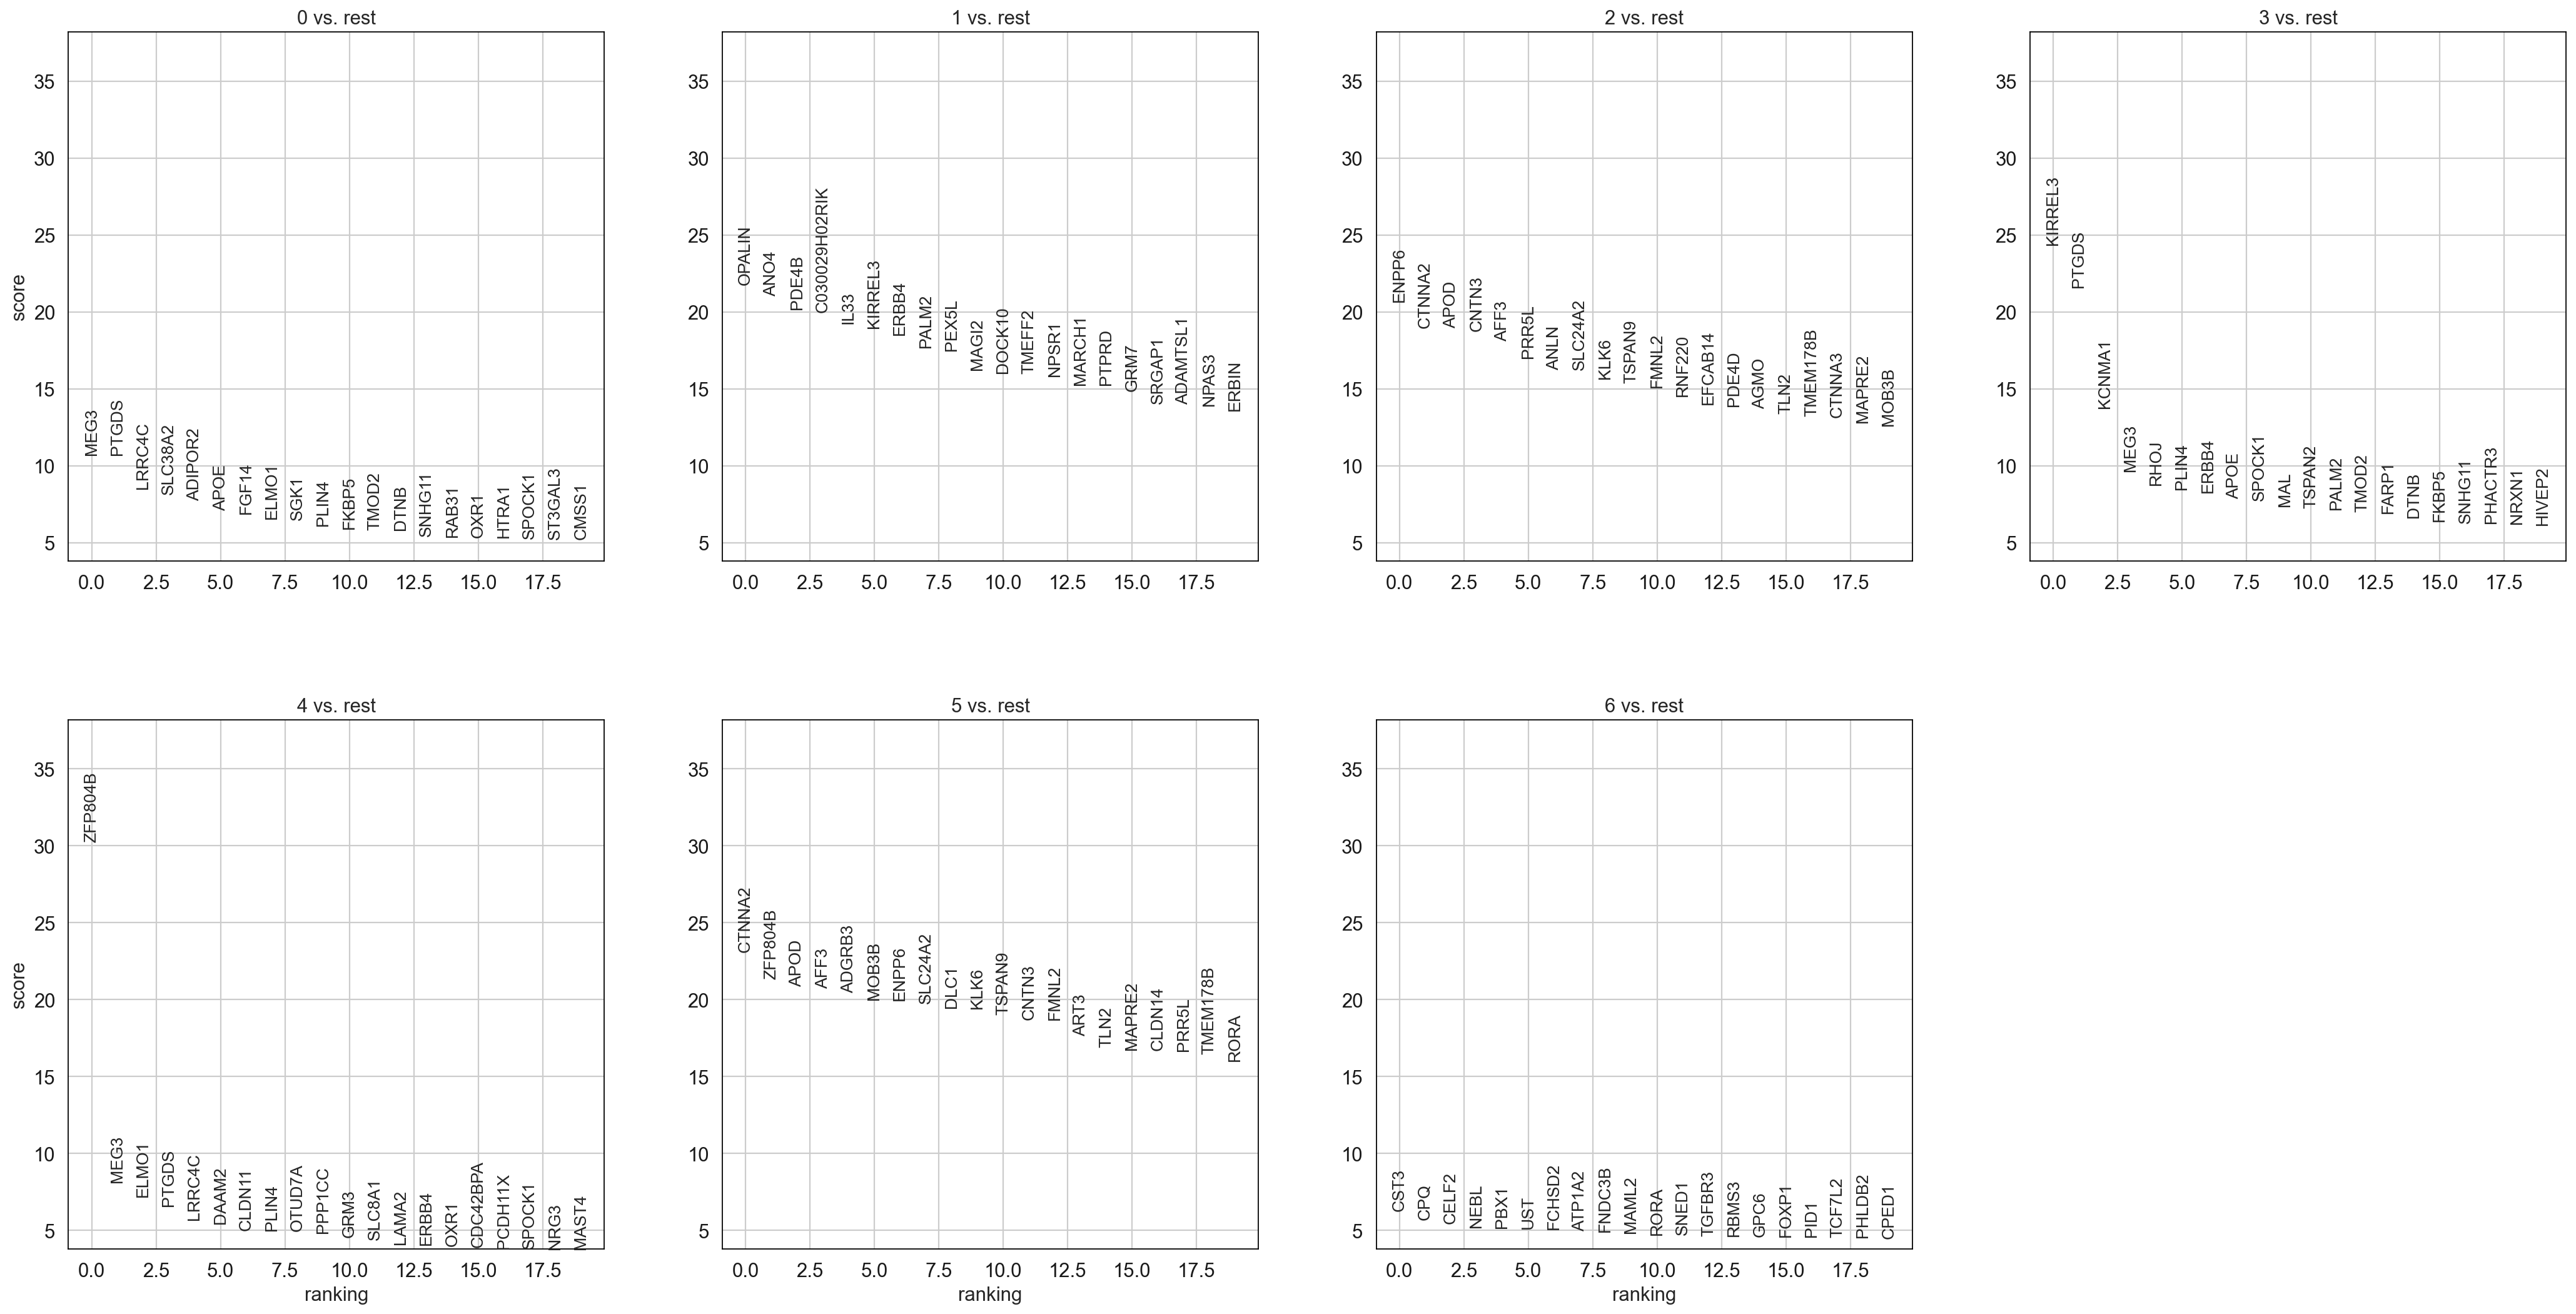

In [46]:
sc.tl.rank_genes_groups(adata_oligo_BS, groupby='PhenoGraph_clusters_oligo_BS', key_added="ranked_genes_pheno_oligo", method='wilcoxon')
sc.pl.rank_genes_groups(adata_oligo_BS, key = 'ranked_genes_pheno_oligo', fontsize=12)

In [59]:
adata_oligo_BS.obs.PhenoGraph_clusters_oligo_BS_str.value_counts()

Oligo0    1060
Oligo1     818
Oligo2     614
Oligo3     606
Oligo4     602
Oligo5     395
Oligo6      37
Name: PhenoGraph_clusters_oligo_BS_str, dtype: int64

## Visualize marker genes using heatmap

In [48]:
adata_oligo_BS.layers['scaled'] = sc.pp.scale(adata_oligo_BS, copy=True).X

/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


{'heatmap_ax': <AxesSubplot:>,
 'groupby_ax': <AxesSubplot:xlabel='PhenoGraph_clusters_oligo_BS_str'>,
 'dendrogram_ax': <AxesSubplot:>,
 'gene_groups_ax': <AxesSubplot:>}

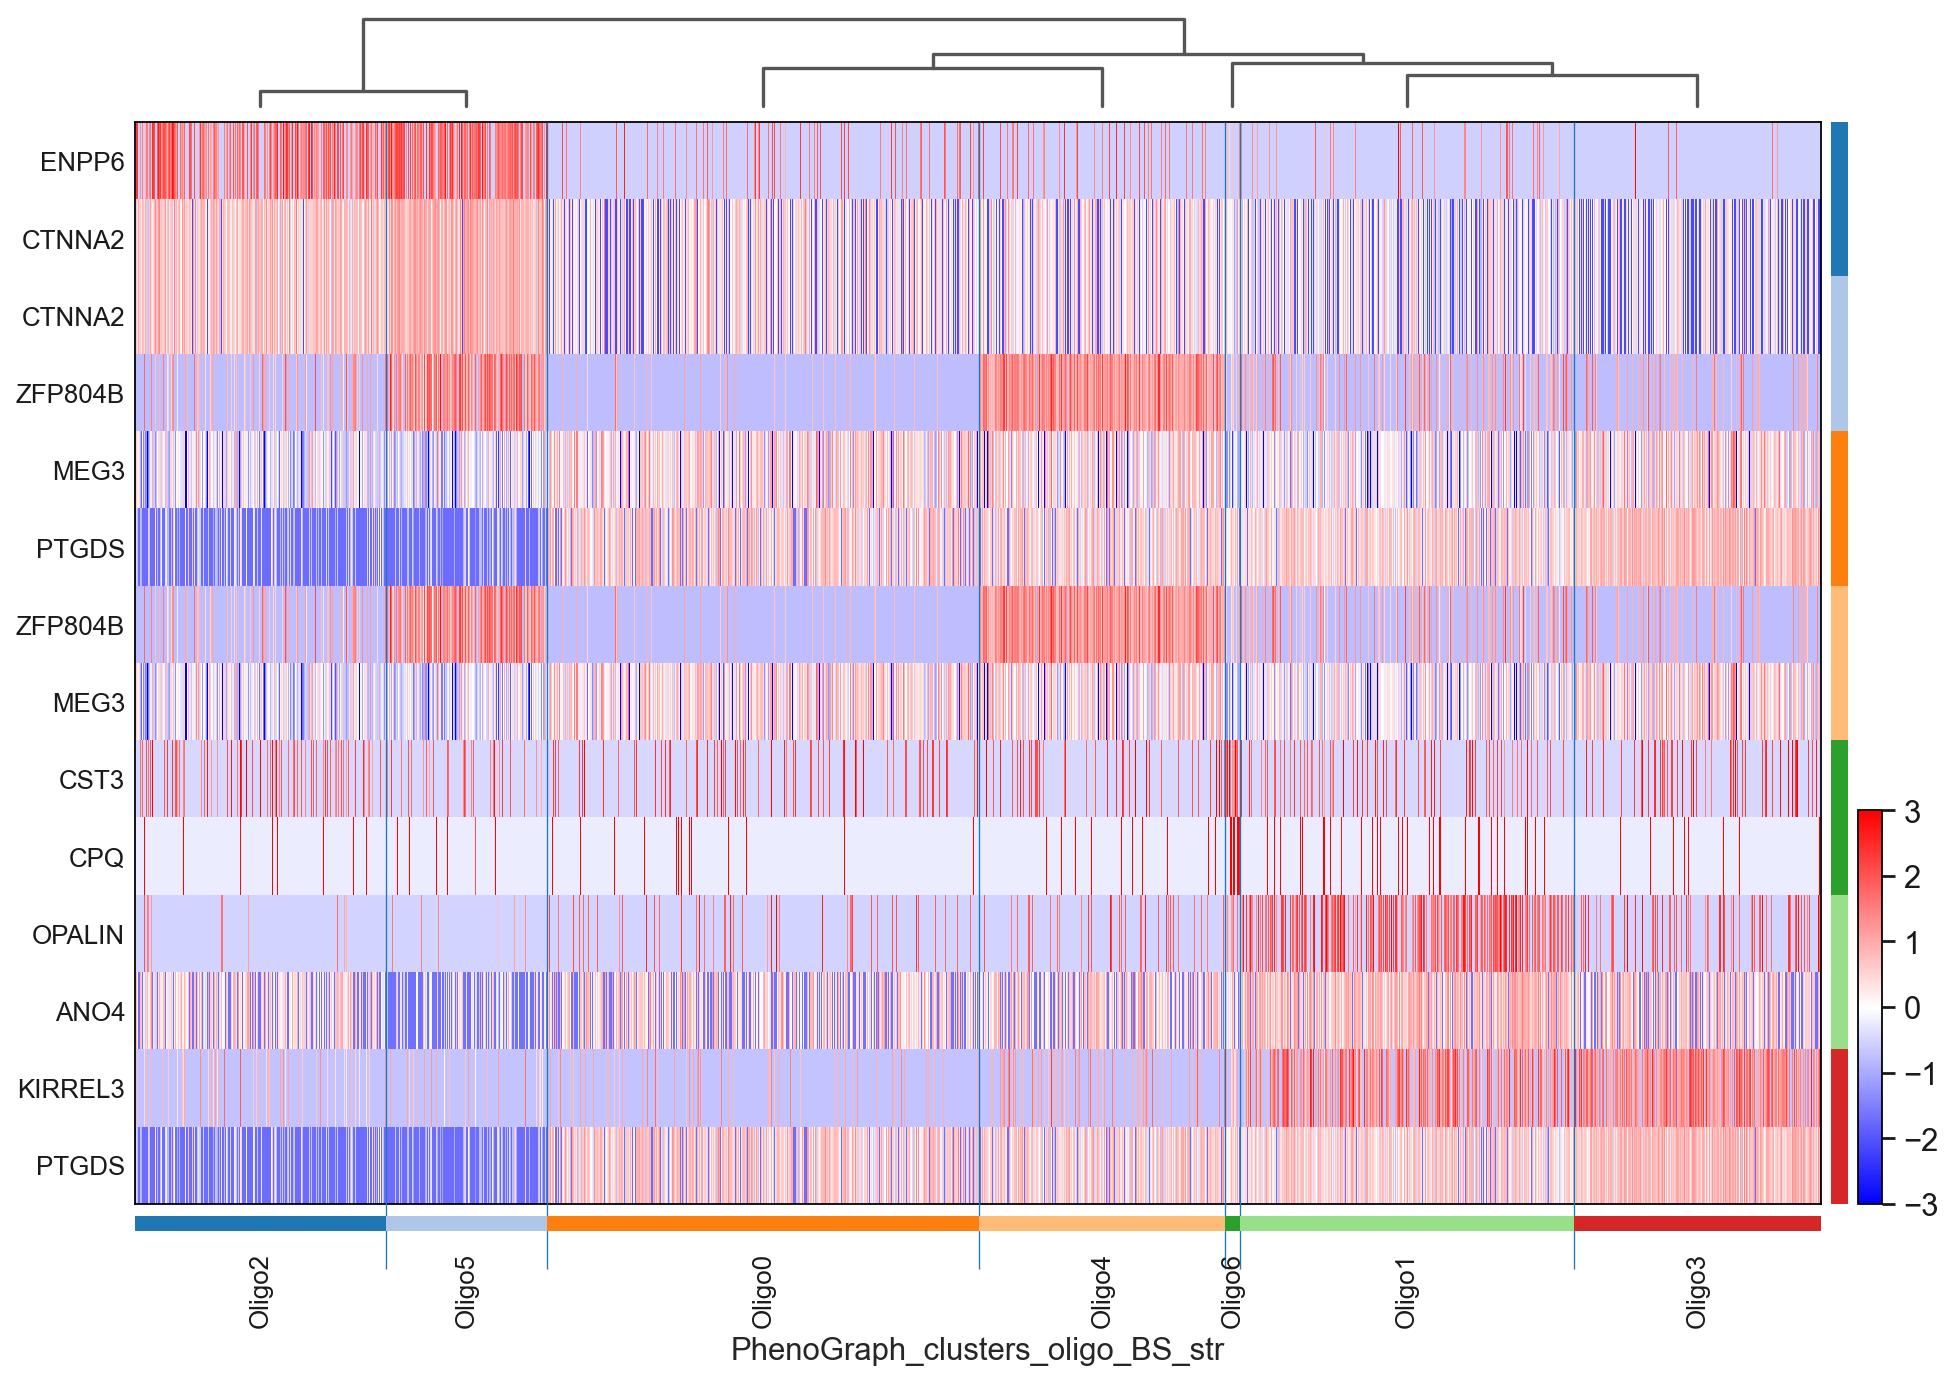

In [49]:
sc.tl.rank_genes_groups(adata_oligo_BS, groupby='PhenoGraph_clusters_oligo_BS_str', n_genes=adata_oligo_BS.shape[1], method='wilcoxon')
sc.pl.rank_genes_groups_heatmap(adata_oligo_BS, n_genes=2, use_raw=False, swap_axes=True, vmin=-3, vmax=3, cmap='bwr', layer='scaled', figsize=(14,10), show=False)

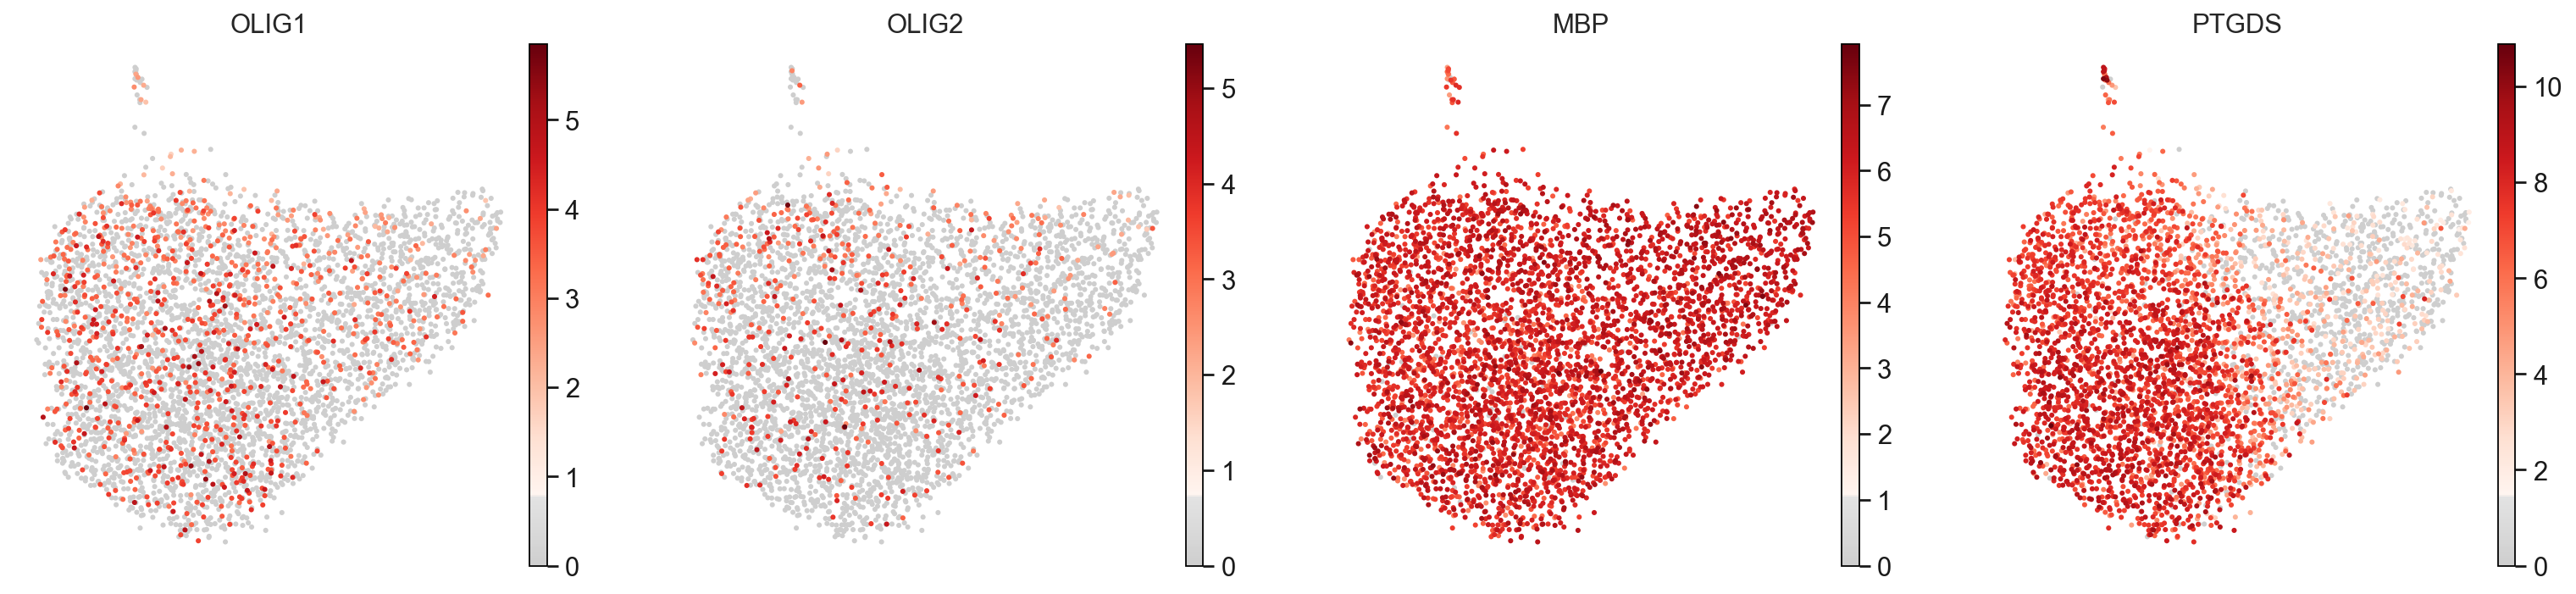

In [50]:
sc.set_figure_params(figsize=(5, 5))
colors2 = plt.cm.Reds(np.linspace(0, 1, 128))
colors3 = plt.cm.Greys_r(np.linspace(0.7,0.8,20))
colorsComb = np.vstack([colors3, colors2])
mymap = matplotlib.colors.LinearSegmentedColormap.from_list('my_colormap', colorsComb)
 
sc.pl.umap(adata_oligo_BS,
           size = 30,
           color=['OLIG1','OLIG2','MBP','PTGDS'],
           color_map=mymap,
          frameon=False, )

**PTGDS expression**

/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


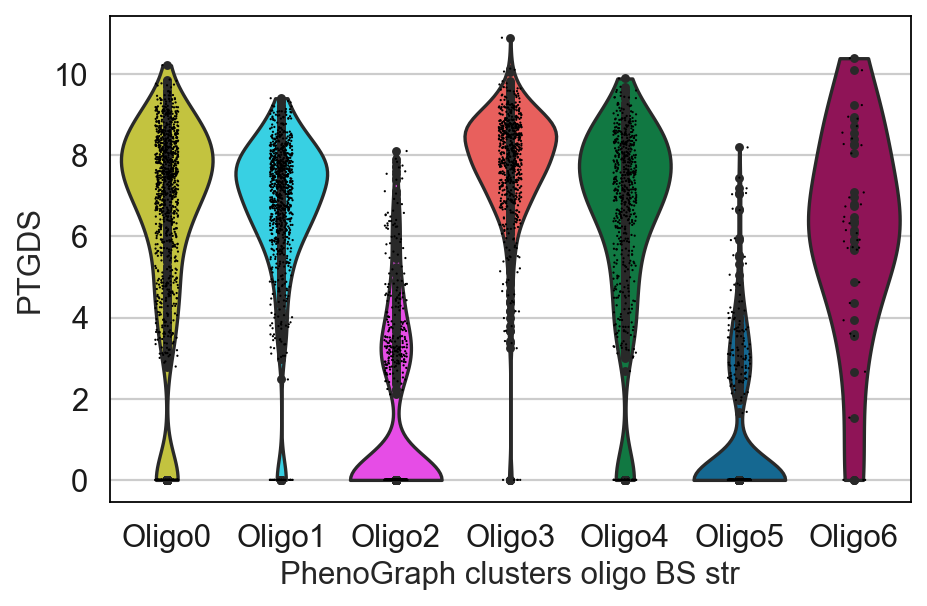

In [87]:
sc.set_figure_params(figsize=(6, 4))
sc.pl.violin(adata_oligo_BS, ['PTGDS'], groupby='PhenoGraph_clusters_oligo_BS_str', inner='point', palette = godsnot_64)

## Oligodendrocytes BS control 

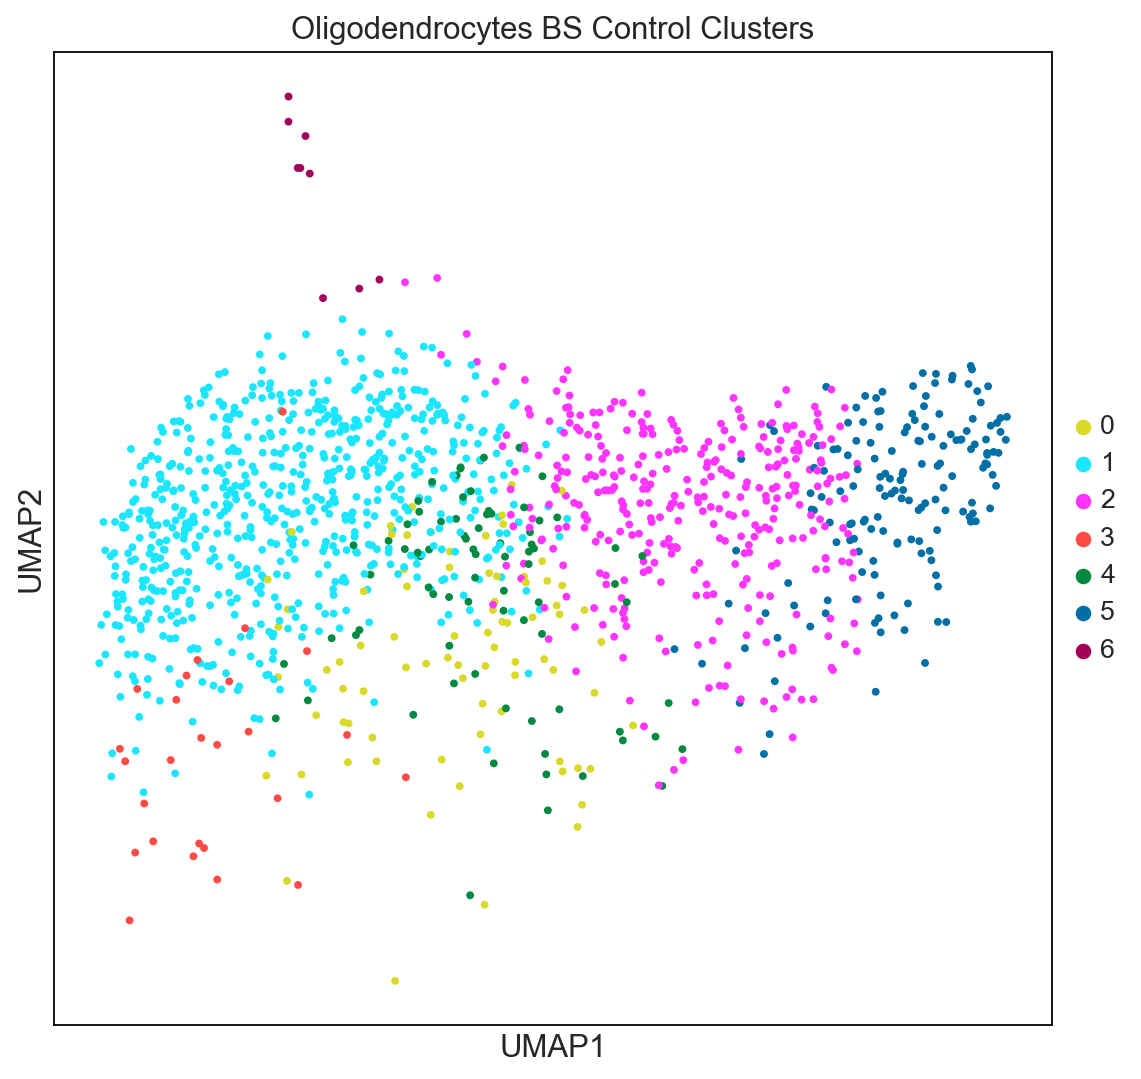

In [76]:
adata_oligo_BS_control = adata_oligo_BS[adata_oligo_BS.obs['Condition'].isin(['Control']),:].copy()

sc.set_figure_params(figsize=(8, 8))
sc.pl.umap(adata_oligo_BS_control, 
           color= ['PhenoGraph_clusters_oligo_BS'],
           ncols=2,
           edges = False,
           edges_width= 0.01,
           palette=godsnot_64,
           size=50, 
           #legend_loc='on data', 
           legend_fontsize=12,
           legend_fontoutline=2,
           title=["Oligodendrocytes BS Control Clusters"])

In [78]:
cell_counts_per_cluster_BS_ctrl = adata_oligo_BS_control.obs.PhenoGraph_clusters_oligo_BS.value_counts()
cell_counts_per_cluster_BS_ctrl = cell_counts_per_cluster_BS_ctrl.to_frame()
cell_counts_per_cluster_BS_ctrl

PhenoGraph_clusters_oligo_BS
1                           680
2                           345
5                           161
0                            80
4                            79
3                            26
6                             9

## Oligodendrocytes BS VE

/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


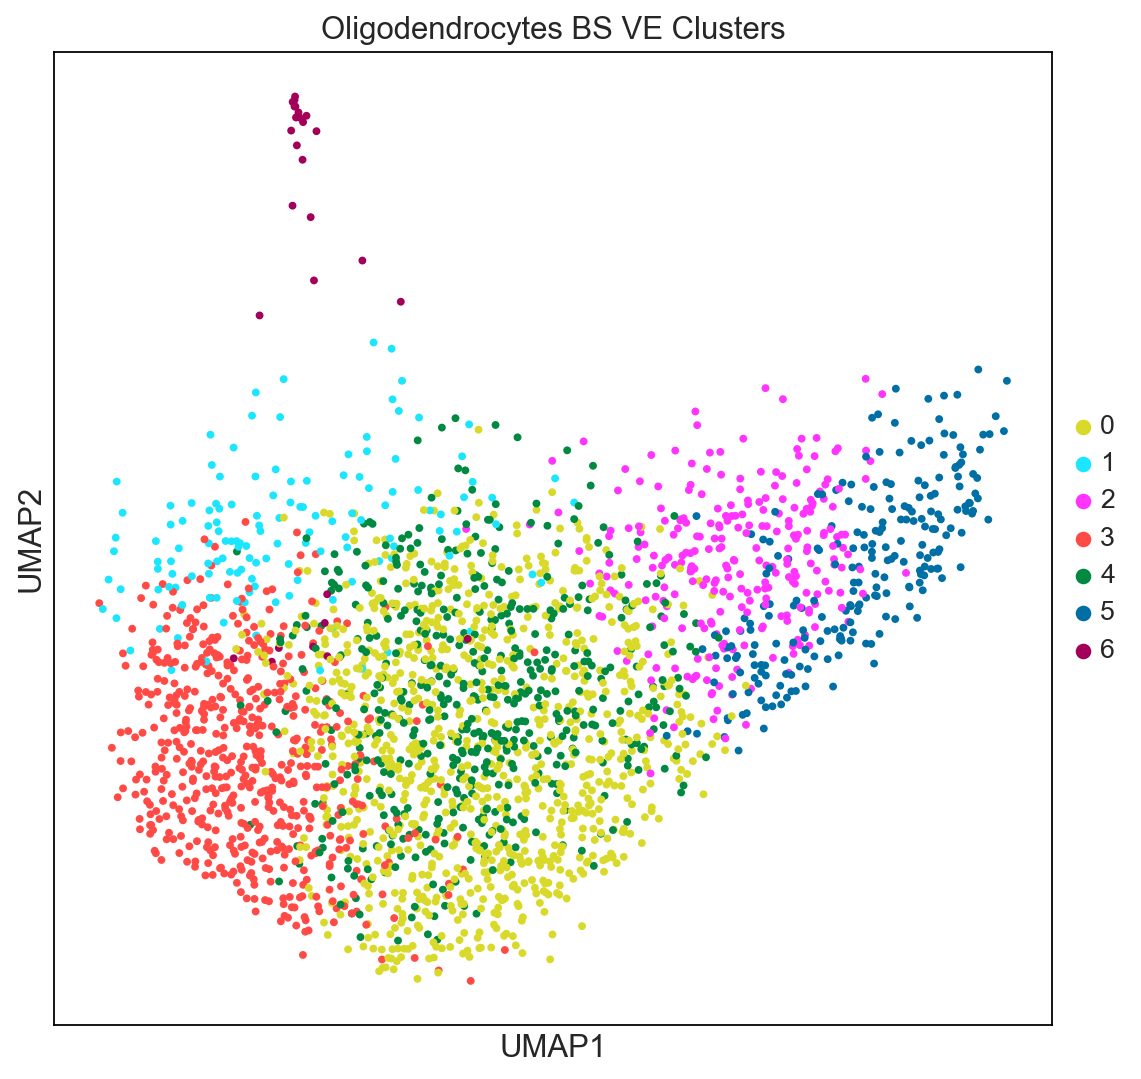

In [79]:
adata_oligo_BS_VE = adata_oligo_BS[adata_oligo_BS.obs['Condition'].isin(['VE']),:].copy()

sc.set_figure_params(figsize=(8, 8))
sc.pl.umap(adata_oligo_BS_VE, 
           color= ['PhenoGraph_clusters_oligo_BS'],
           ncols=2,
           edges = False,
           edges_width= 0.01,
           palette=godsnot_64,
           size=50, 
           #legend_loc='on data', 
           legend_fontsize=12,
           legend_fontoutline=2,
           title=["Oligodendrocytes BS VE Clusters"])

In [80]:
cell_counts_per_cluster_BS_VE = adata_oligo_BS_VE.obs.PhenoGraph_clusters_oligo_BS.value_counts()
cell_counts_per_cluster_BS_VE = cell_counts_per_cluster_BS_VE.to_frame()
cell_counts_per_cluster_BS_VE

PhenoGraph_clusters_oligo_BS
0                           980
3                           580
4                           523
2                           269
5                           234
1                           138
6                            28

## Make a grouped bar plot of the number of cells per cluster per condition

**Brainstem**

In [81]:
# First merge the 2 data frames by indeces
mergedDF= cell_counts_per_cluster_BS_ctrl.merge(cell_counts_per_cluster_BS_VE, left_index=True, right_index=True, suffixes=('_Control', '_VE'),how = 'outer')
mergedDF.rename(columns = {'PhenoGraph_clusters_oligo_BS_Control' : 'Control', 'PhenoGraph_clusters_oligo_BS_VE' : 'VE'}, inplace = True)
mergedDF

Control   VE
0       80  980
1      680  138
2      345  269
3       26  580
4       79  523
5      161  234
6        9   28

In [82]:
mergedDF = mergedDF.reset_index()
mergedDF = mergedDF.melt(id_vars=["index"])
mergedDF.rename(columns = {'index' : 'ClusterID', 'variable' : 'Condition', 'value' : 'N_cells'}, inplace = True)
mergedDF

ClusterID Condition  N_cells
0          0   Control       80
1          1   Control      680
2          2   Control      345
3          3   Control       26
4          4   Control       79
5          5   Control      161
6          6   Control        9
7          0        VE      980
8          1        VE      138
9          2        VE      269
10         3        VE      580
11         4        VE      523
12         5        VE      234
13         6        VE       28

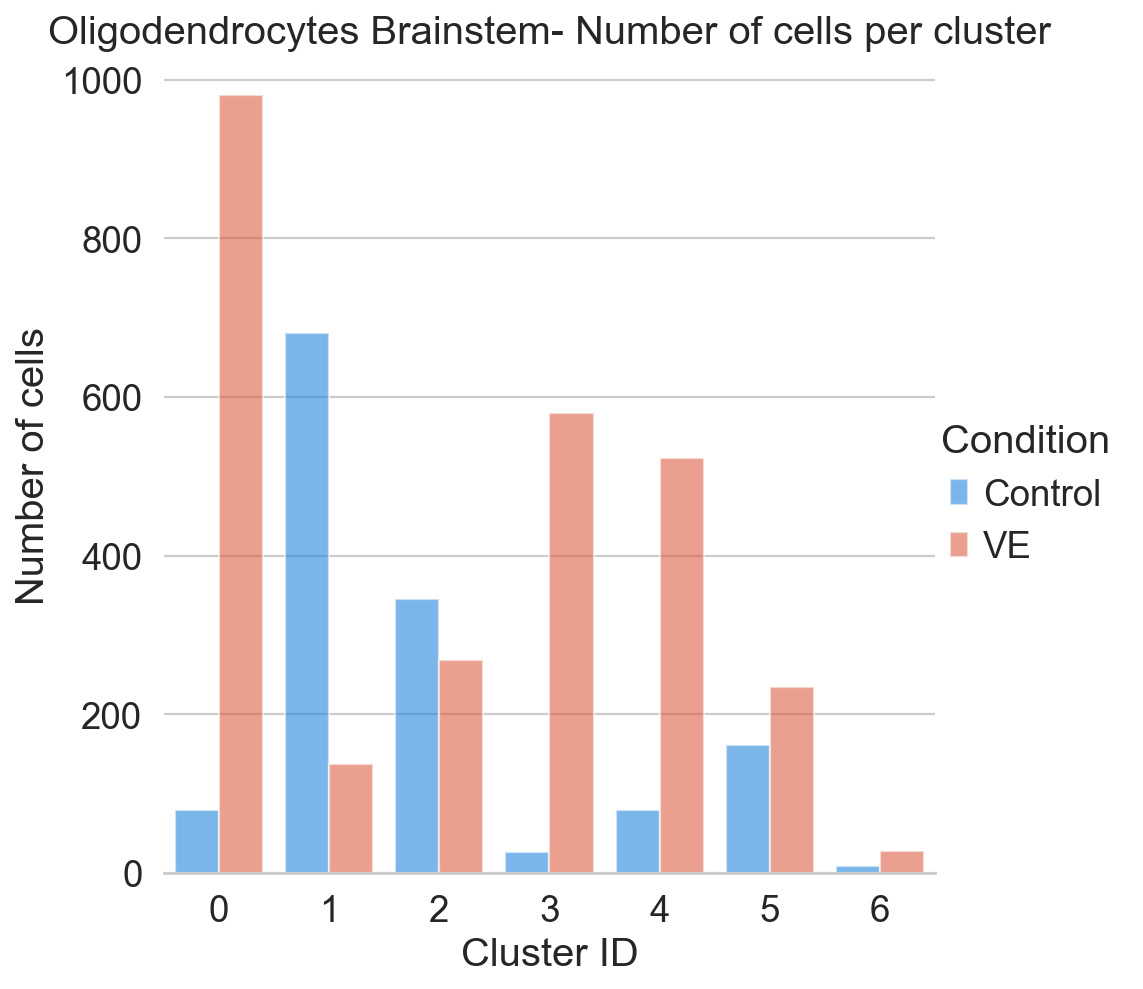

In [83]:
sns.set(font_scale=1.5, style = 'whitegrid') 
# Draw a nested barplot by species and sex
g = sns.catplot(
    data=mergedDF, kind="bar",
    x="ClusterID", y="N_cells", hue="Condition",
    ci="sd", palette=['#0488FC','#F64E2C'], alpha=.6, height=6
)
g.despine(left=True)
g.set(title='Oligodendrocytes Brainstem- Number of cells per cluster')
g.set_axis_labels("Cluster ID", "Number of cells")

## Compare Clusters 0+1+3+4+6 (VE) Versus All Controls

### T-test 

In [54]:
adata_oligo_BS_copy = adata_oligo_BS.copy()
# For loop creating a groups for pairwise comparison
adata_oligo_BS_copy.obs['groups'] = ['group_0_1_3_4_6VE' if int(i) in [0,1,3,4,6] and j == 'VE' else 'group_restCTRL' if j == 'Control' else 'Error' for i,j in zip(adata_oligo_BS_copy.obs['PhenoGraph_clusters_oligo_BS'],adata_oligo_BS_copy.obs['Condition'] )]


In [55]:
adata_oligo_BS_copy.obs.groups.value_counts()

group_0_1_3_4_6VE    2249
group_restCTRL       1380
Error                 503
Name: groups, dtype: int64

In [52]:
#adata_oligo_BS_copy.obs[['groups','PhenoGraph_clusters_astro','PhenoGraph_clusters_astro_str','Condition']]

In [56]:
# select only cells that are in these 2 groups that I want to compare
adata_oligo_BS_to_compare = adata_oligo_BS_copy[[group in ['group_restCTRL', 'group_0_1_3_4_6VE'] for group in adata_oligo_BS_copy.obs['groups']],].copy()
adata_oligo_BS_to_compare.obs.groups.value_counts()

/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


group_0_1_3_4_6VE    2249
group_restCTRL       1380
Name: groups, dtype: int64

... storing 'groups' as categorical


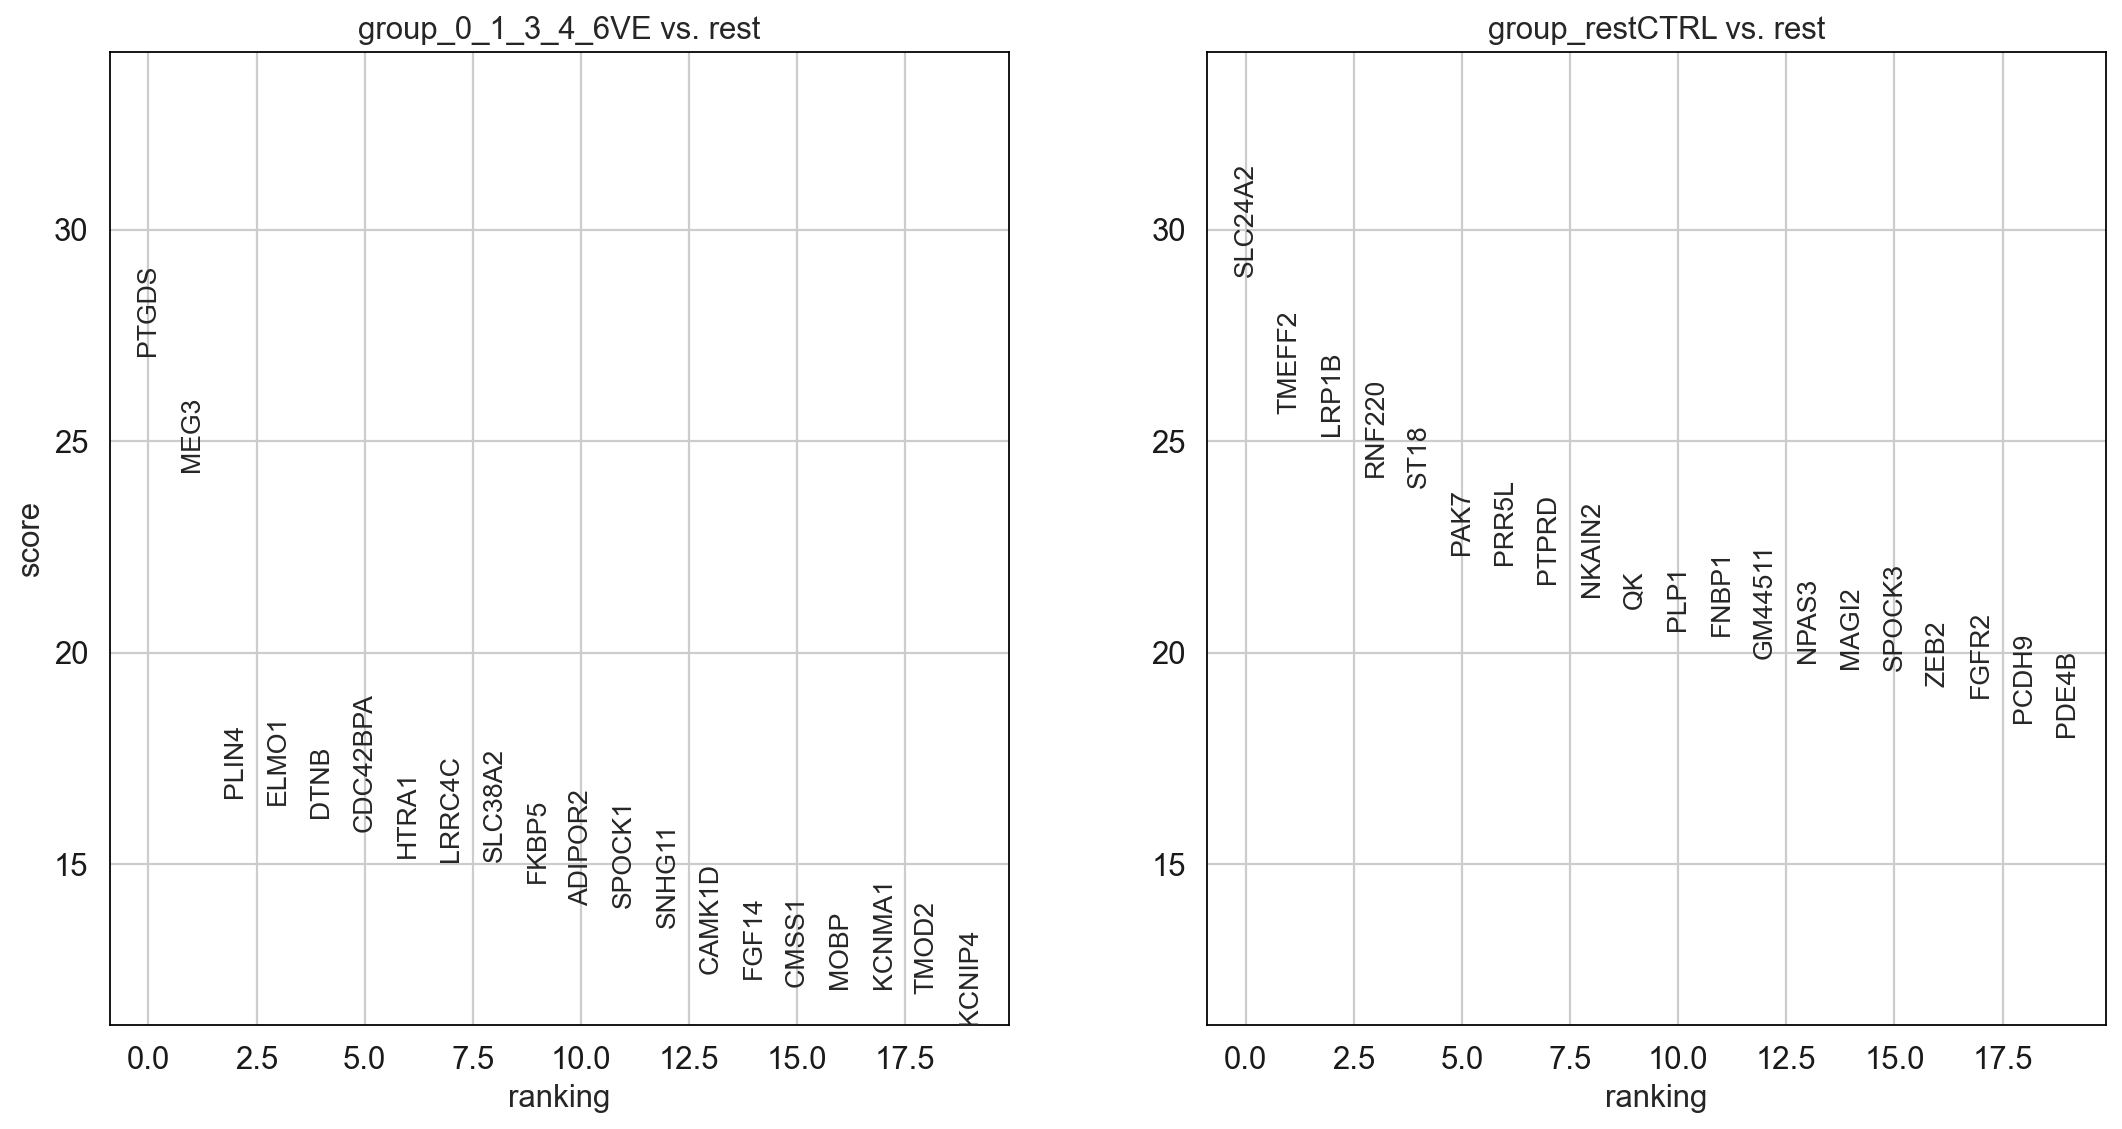

In [57]:
sc.set_figure_params(figsize=(8, 8))
key_ad = 'group_0_1_3_4_6VE'
n_genes = 100000

sc.tl.rank_genes_groups(adata_oligo_BS_to_compare, groupby='groups', key_added="group_0_1_3_4_6VE", method='wilcoxon')
sc.pl.rank_genes_groups(adata_oligo_BS_to_compare, key = 'group_0_1_3_4_6VE', fontsize=12)

result = adata_oligo_BS_to_compare.uns[key_ad]
groups = result['names'].dtype.names
pval_table = pd.DataFrame(
        {group + '_' + key[:1]: result[key][group]
        for group in groups for key in ['names','logfoldchanges', 'pvals_adj']}).head(n_genes)
#pval_table.to_excel(os.path.join("/Users/fragkogs/Desktop/", key_ad + '_' + method + '_pval_table_' + '_clusters_' + str(n_genes) + 'genes_filtered_corrected.xlsx'), engine='openpyxl')

In [58]:
pval_table = pval_table.sort_values(by= 'group_0_1_3_4_6VE_l', ascending=False)
pval_table[(pval_table.group_0_1_3_4_6VE_p < 0.05) & (pval_table.group_0_1_3_4_6VE_l > 0.5)].head(10)

group_0_1_3_4_6VE_n  group_0_1_3_4_6VE_l  group_0_1_3_4_6VE_p  \
2                 PLIN4             4.225163         5.567305e-59   
0                 PTGDS             3.843487        6.082315e-157   
33                  C4B             3.362938         5.610874e-16   
9                 FKBP5             3.091689         1.397361e-45   
73                ITIH5             3.028008         3.280865e-05   
128              CDKN1A             2.985809         2.533966e-02   
24                HIF3A             2.827963         2.666347e-22   
31                 GLI2             2.450438         3.626732e-16   
4                  DTNB             2.261040         1.139806e-55   
6                 HTRA1             2.066898         2.188581e-49   

    group_restCTRL_n  group_restCTRL_l  group_restCTRL_p  
2              LRP1B          1.131015     8.452809e-136  
0            SLC24A2          1.332979     2.383276e-179  
33             RAP1A          2.196066      4.151673e-50  
9                 QK          1.300688      2.734264e-95  
73             TULP4          1.474833      8.802646e-28  
128            PARD3          1.334436      3.223940e-19  
24              CAR2          1.999591      1.263211e-54  
31           DPY19L1          1.984198      5.585259e-51  
4               ST18          1.720089     6.858345e-123  
6              PRR5L          1.313372     9.450848e-105

### MAST 

In [62]:
cell_type = 'Oligodendrocytes_C0_1_3_4_6'
expmat = pd.DataFrame(adata_oligo_BS_to_compare.X, columns = adata_oligo_BS_to_compare.var.index, index = adata_oligo_BS_to_compare.obs.index)
cdata = pd.DataFrame(adata_oligo_BS_to_compare.obs, columns=adata_oligo_BS_to_compare.obs.columns, index = adata_oligo_BS_to_compare.obs.index)
expmat.to_csv(r'../DEA/'+ cell_type + '/adata_'+ cell_type+ '_exp_mat.csv', index=True)
cdata.to_csv(r'../DEA/'+ cell_type + '/adata_'+ cell_type+ '_cdata.csv', index=True)

In [66]:
start_time = timeit.default_timer()
MAST = './runMAST_clusters.R'
expmat_Inputfile = ('../DEA/'+ cell_type + '/adata_'+ cell_type+ '_exp_mat.csv')
cdata_Inputfile = ('../DEA/'+ cell_type + '/adata_'+ cell_type+ '_cdata.csv')
output_file_cort = '../DEA/' +  cell_type + "/MAST_DEA_" + cell_type + "_RESULTS.csv" 

os.system(MAST + " " + expmat_Inputfile + " " + cdata_Inputfile + " " + output_file_cort + " " )
out_str = "Finished running MAST on"+ "( " + cell_type +  ")" +" in {} seconds.".format(timeit.default_timer()-start_time)

In [67]:
# import the MAST results
mast_C0_1_3_4_6_res = pd.read_csv (filepath_or_buffer= '../DEA/Oligodendrocytes_C0_1_3_4_6/MAST_DEA_Oligodendrocytes_C0_1_3_4_6_RESULTS.csv')
print(mast_C0_1_3_4_6_res)

                 gene              p      p.fdr.adj     logFC
0               PLIN4  1.318253e-112  1.738249e-108  1.306406
1               FKBP5  1.067928e-107  7.040852e-104  1.371804
2              TMEFF2  5.546607e-105  2.437919e-101 -0.873238
3             SLC24A2   5.704707e-99   1.880557e-95 -0.709426
4                PLP1   1.141064e-92   3.009213e-89 -0.524085
...               ...            ...            ...       ...
13181          PEX11A   9.997431e-01   9.999786e-01 -0.000453
13182           UNC5A   9.997511e-01   9.999786e-01 -0.000394
13183         DENND1C   9.998678e-01   1.000000e+00 -0.000393
13184          RAD54B   1.000000e+00   1.000000e+00 -0.000060
13185  X1700016D06RIK   1.000000e+00   1.000000e+00  0.000444

[13186 rows x 4 columns]


In [135]:
#filter DE results
mast_C0_1_3_4_6_res = mast_C0_1_3_4_6_res.sort_values(by='logFC', ascending=False)
# Upregulated genes
mast_C0_1_3_4_6_res_UP = mast_C0_1_3_4_6_res[(mast_C0_1_3_4_6_res['logFC'] >=0.01) & (mast_C0_1_3_4_6_res['p.fdr.adj'] <= 0.05)]
mast_C0_1_3_4_6_res_res_DOWN = mast_C0_1_3_4_6_res[(mast_C0_1_3_4_6_res['logFC'] <=0.01) & (mast_C0_1_3_4_6_res['p.fdr.adj'] <= 0.05)]
mast_C0_1_3_4_6_res_res_DOWN['gene'].shape

(2344,)

### HEATMAP OF TOP10 UPREGULATED GENES

In [150]:
marker_genes_dict = dict()

marker_genes_dict = {'C0_1_3_4_6_UP': mast_C0_1_3_4_6_res_UP['gene'].head(20)}

/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/scanpy/plotting/_matrixplot.py:222: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  __ = ax.pcolor(_color_df, **kwds)


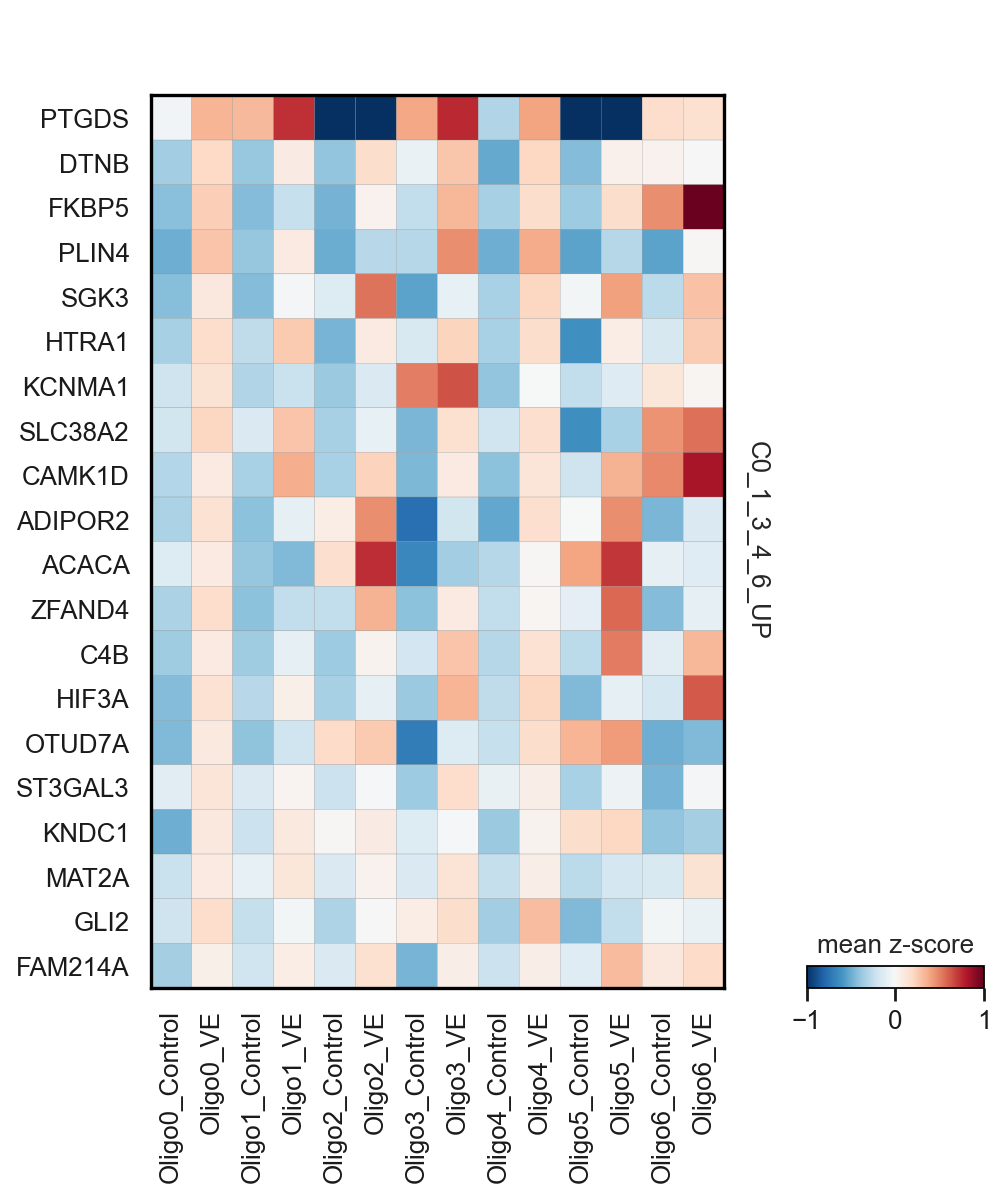

categories: Oligo0_Control, Oligo0_VE, Oligo1_Control, etc.
var_group_labels: C0_1_3_4_6_UP


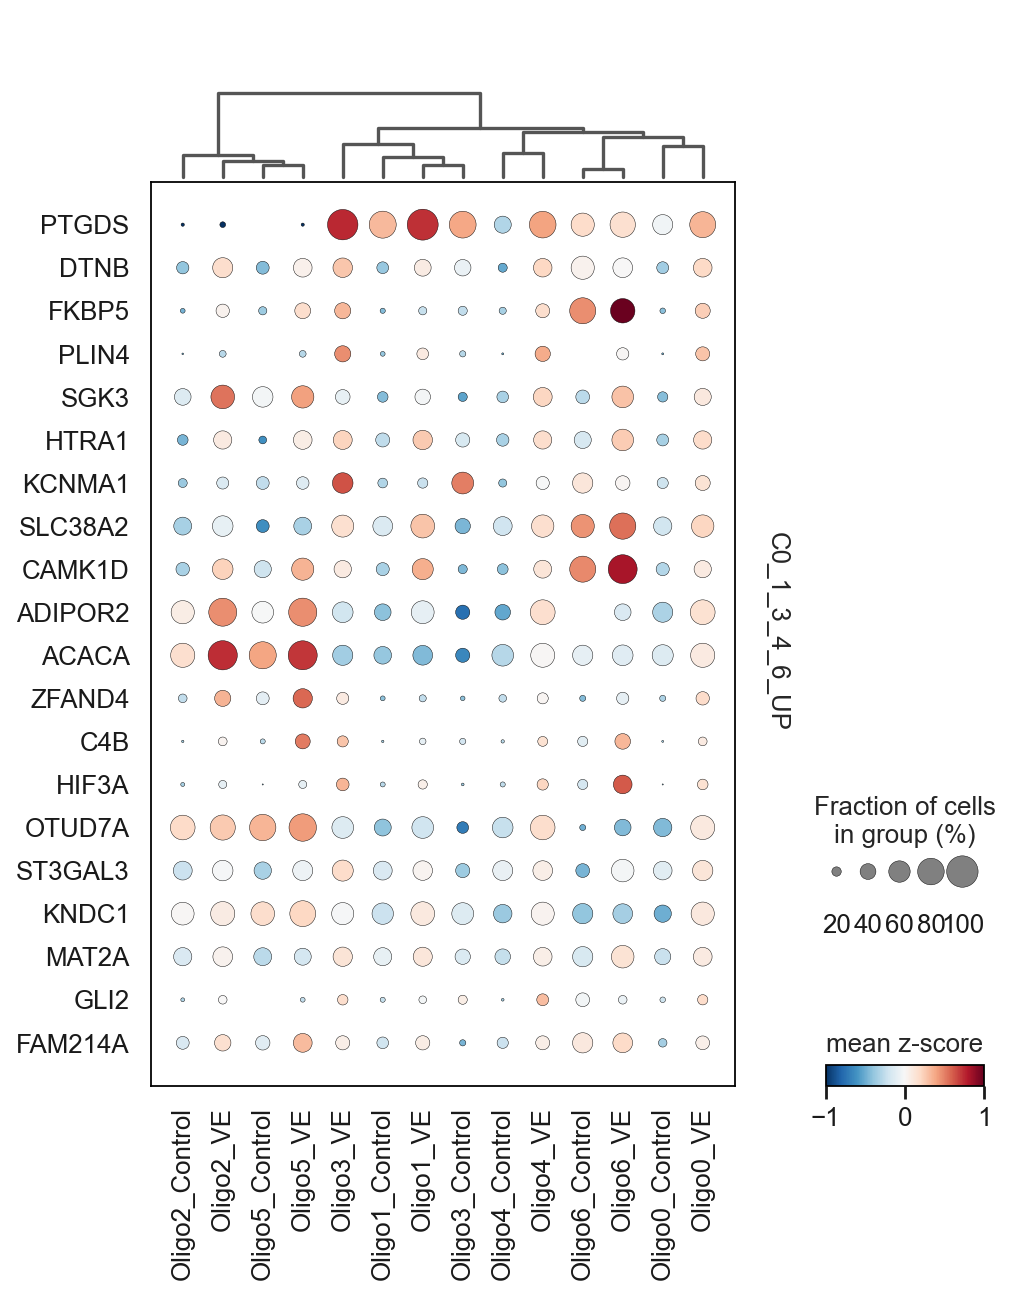

/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


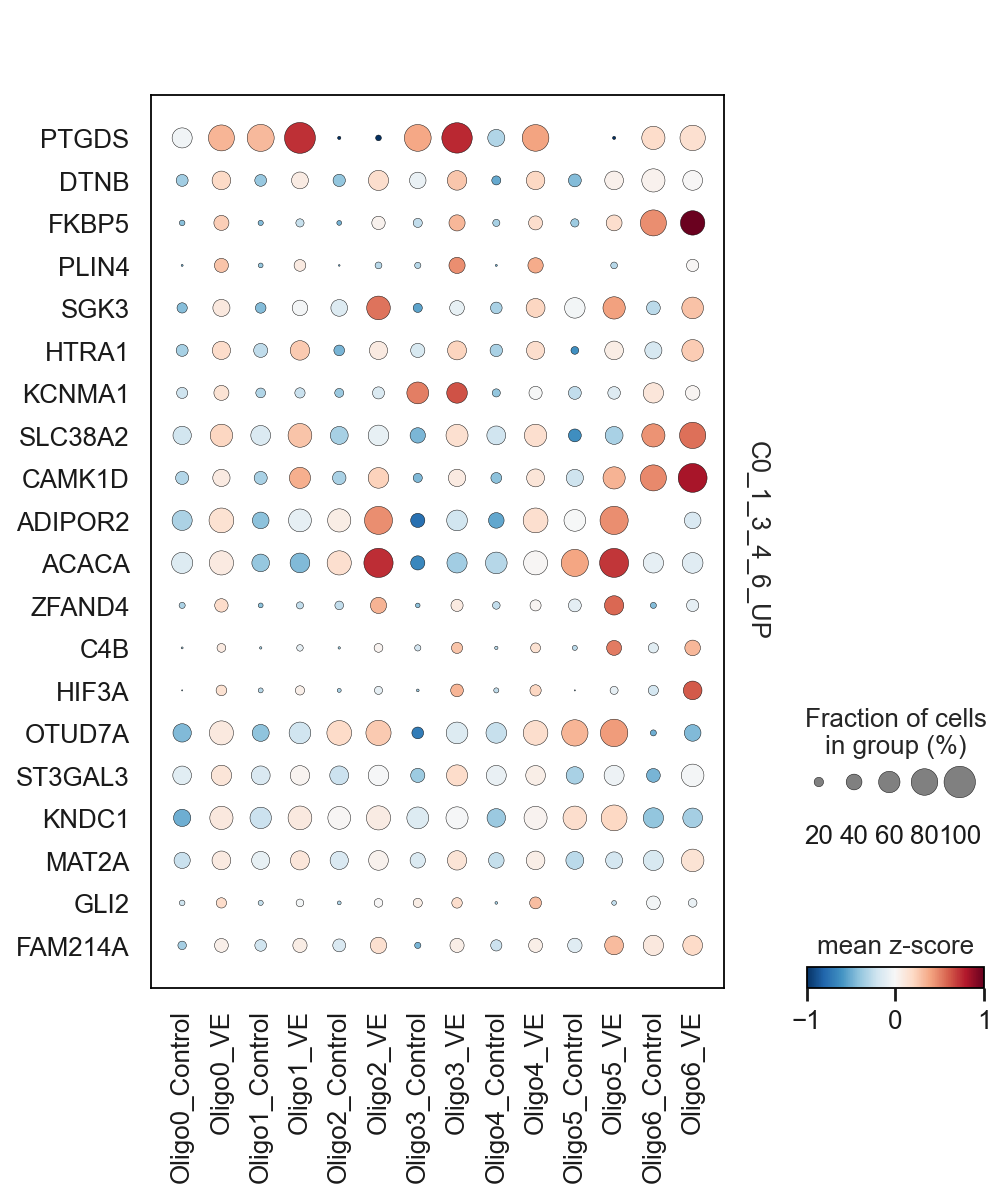

In [151]:
adata_oligo_BS.layers['scaled'] = sc.pp.scale(adata_oligo_BS, copy=True).X
sc.pl.matrixplot(adata_oligo_BS, marker_genes_dict, groupby=['PhenoGraph_clusters_oligo_BS_str','Condition'], dendrogram=False,
                 colorbar_title='mean z-score', layer='scaled', vmin=-1, vmax=1, cmap='RdBu_r',swap_axes=True)

sc.pl.dotplot(adata_oligo_BS, marker_genes_dict, groupby=['PhenoGraph_clusters_oligo_BS_str','Condition'], dendrogram=True,
             colorbar_title='mean z-score', layer='scaled', vmin=-1, vmax=1, cmap='RdBu_r',swap_axes=True)

sc.pl.dotplot(adata_oligo_BS, marker_genes_dict, groupby=['PhenoGraph_clusters_oligo_BS_str','Condition'], dendrogram=False,
             colorbar_title='mean z-score', layer='scaled', vmin=-1, vmax=1, cmap='RdBu_r',swap_axes=True)

### Enricher

In [173]:
#Available databases : ‘Human’, ‘Mouse’, ‘Yeast’, ‘Fly’, ‘Fish’, ‘Worm’ 
import gseapy
gene_set_names = gseapy.get_library_name(database='Mouse')
#print(gene_set_names)

mast_mast_C0_1_3_4_6_res_n_list = mast_C0_1_3_4_6_res_res_DOWN.gene.str.strip().tolist()
enr_res = gseapy.enrichr(gene_list=mast_mast_C0_1_3_4_6_res_n_list,
                     organism='Mouse',
                     gene_sets=['WikiPathways_2019_Mouse'],
                     description='pathway',
                     cutoff = 0.5)

In [174]:
enr_res.results.head(10)

Gene_set                                               Term  \
0  WikiPathways_2019_Mouse                     Cholesterol Biosynthesis WP103   
1  WikiPathways_2019_Mouse  Cholesterol metabolism (includes both Bloch an...   
2  WikiPathways_2019_Mouse                 G Protein Signaling Pathways WP232   
3  WikiPathways_2019_Mouse  Myometrial Relaxation and Contraction Pathways...   
4  WikiPathways_2019_Mouse  Primary Focal Segmental Glomerulosclerosis FSG...   
5  WikiPathways_2019_Mouse                       Proteasome Degradation WP519   
6  WikiPathways_2019_Mouse                             Insulin Signaling WP65   
7  WikiPathways_2019_Mouse                Integrin-mediated Cell Adhesion WP6   
8  WikiPathways_2019_Mouse                Neural Crest Differentiation WP2074   
9  WikiPathways_2019_Mouse                                Focal Adhesion WP85   

  Overlap       P-value  Adjusted P-value  Old P-value  Old Adjusted P-value  \
0   10/15  8.246146e-07          0.000131            0                     0   
1   18/49  5.172209e-06          0.000411            0                     0   
2   24/92  1.123816e-04          0.005956            0                     0   
3  33/153  3.601378e-04          0.014315            0                     0   
4   19/72  4.797393e-04          0.015256            0                     0   
5   15/52  6.719781e-04          0.016785            0                     0   
6  33/159  7.389803e-04          0.016785            0                     0   
7  23/100  1.070572e-03          0.021278            0                     0   
8  23/101  1.235258e-03          0.021823            0                     0   
9  36/185  1.490983e-03          0.023707            0                     0   

   Odds Ratio  Combined Score  \
0   15.125107      211.877790   
1    4.399773       53.554958   
2    2.675659       24.331402   
3    2.086716       16.545618   
4    2.714198       20.742625   
5    3.066912       22.404665   
6    1.986668       14.324354   
7    2.262331       15.473353   
8    2.233200       14.954568   
9    1.832703       11.927819   

                                               Genes  
0  SQLE;NSDHL;MVK;HMGCS1;SC5D;MSMO1;HMGCR;DHCR7;C...  
1  SREBF1;MVK;HMGCS1;ACSL1;ELOVL5;MSMO1;ACSL3;HMG...  
2  PDE1C;PDE4D;AKAP7;PRKCA;AKAP6;ADCY2;GNG12;PRKC...  
3  ATF1;ATF2;ATF6B;LPAR1;ATP2A2;ADCY2;PRKCZ;ACTB;...  
4  SCARB2;ITGB1;KIRREL3;ITGB4;LAMB2;ITGB3;ACTN4;D...  
5  RPN2;RPN1;UBE2D1;UBE2D2A;PSMB7;PSMD6;PSMA3;PSM...  
6  GSK3B;PTEN;PIK3R3;PIK3R1;PRKCZ;IKBKB;LIPE;RPS6...  
7  ITGB1;GIT2;MAP2K2;ITGA4;ITGB4;ITGB3;ITGA2;ARAF...  
8  ITGB1;HDAC4;GSK3B;HDAC3;HDAC11;COL11A2;MITF;OL...  
9  ITGB1;GSK3B;LAMA2;ITGB4;ITGB3;COL11A2;ARAF;PTE...

<AxesSubplot:title={'center':'WikiPathways_2019_Mouse'}, xlabel='-log$_{10}$(Adjusted P-value)'>

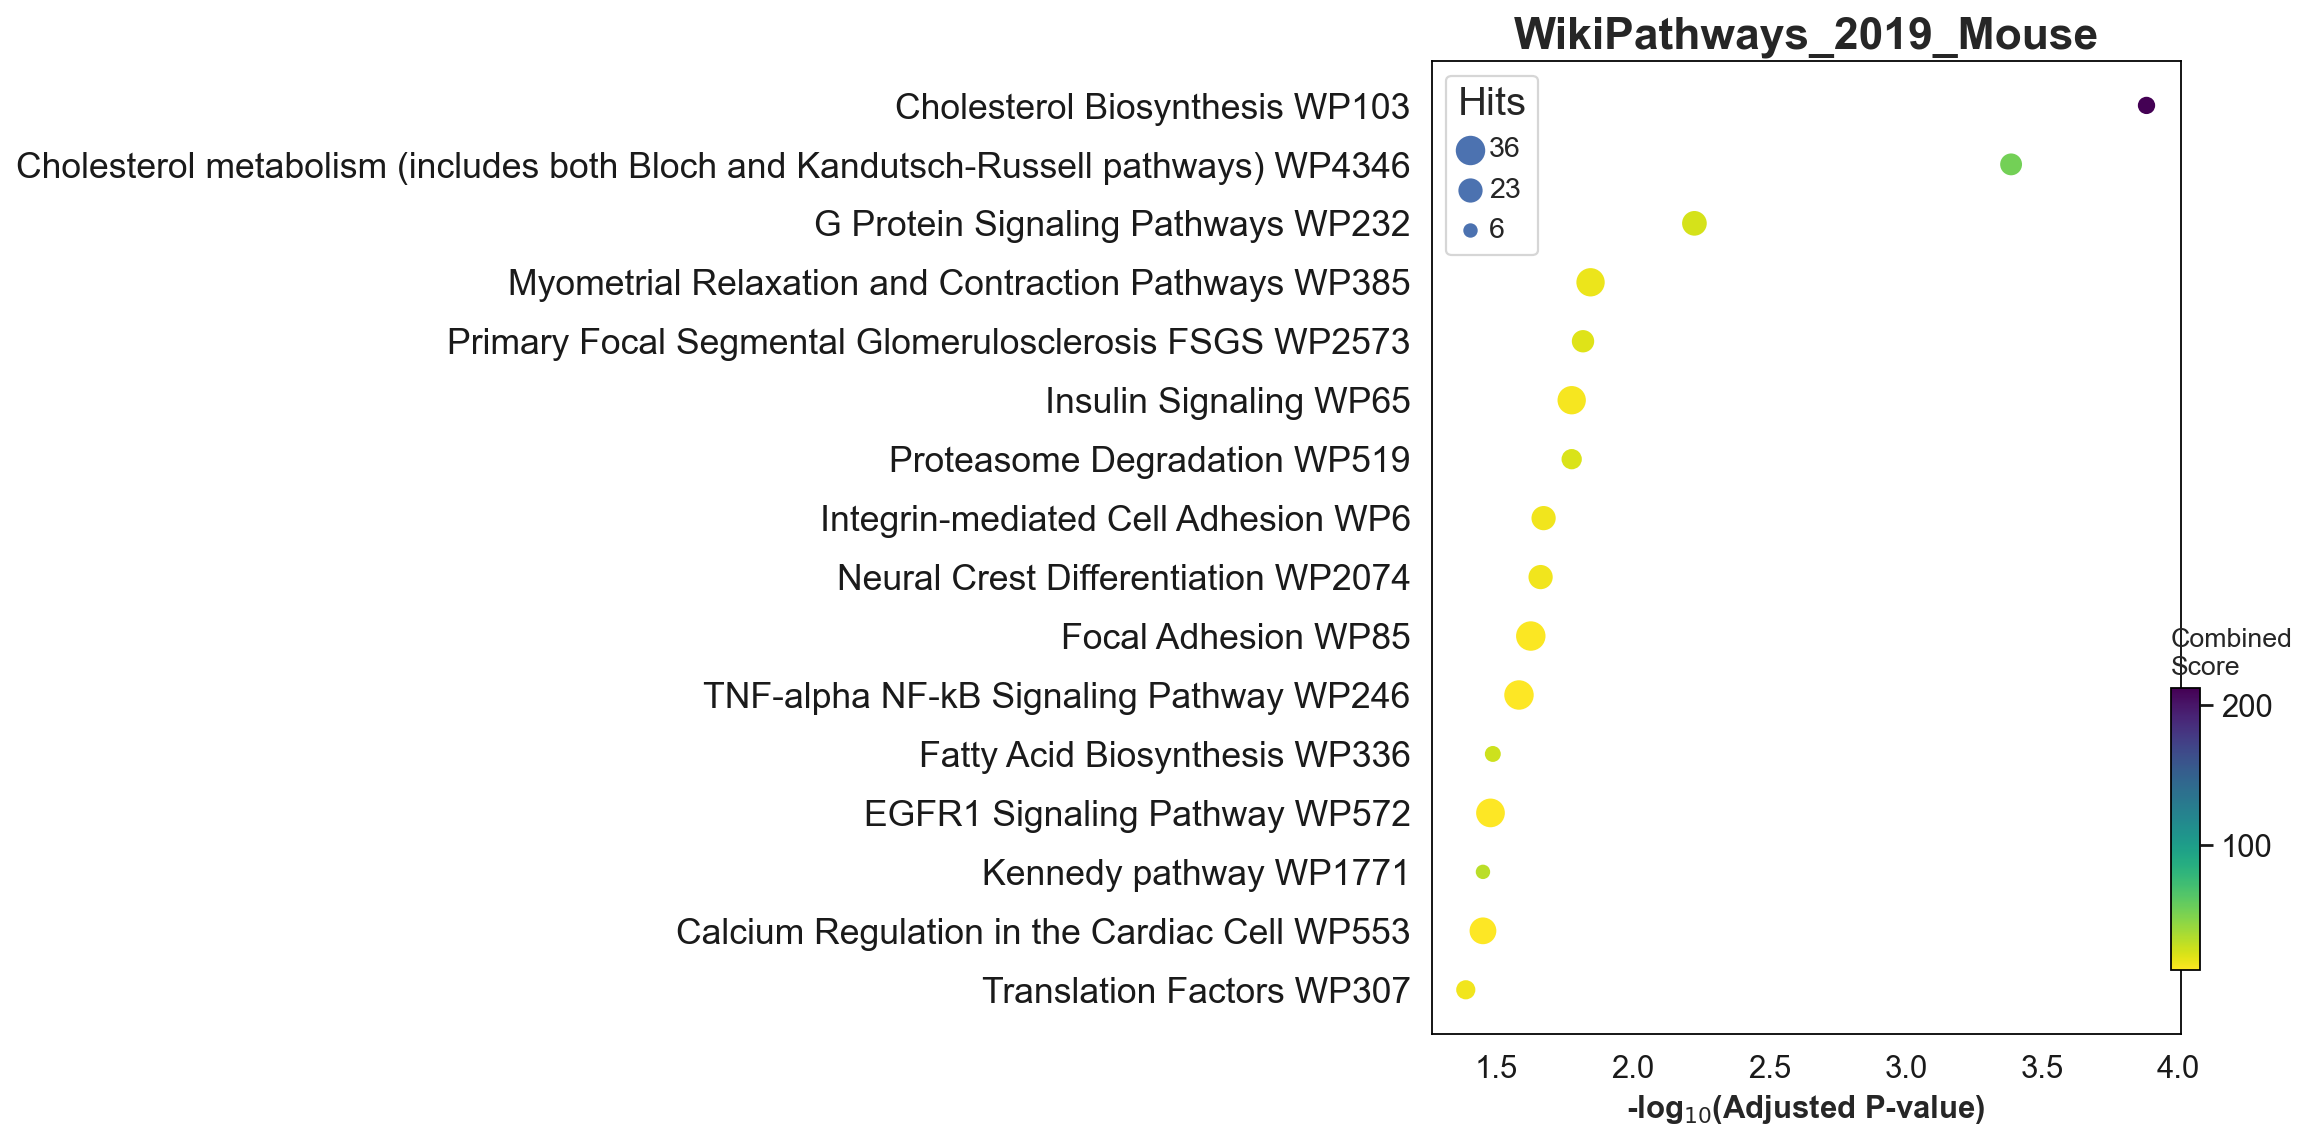

In [175]:
gseapy.dotplot(enr_res.res2d, title='WikiPathways_2019_Mouse',cmap='viridis_r', top_term=20, figsize=(6,8))

### GSEA pre-rank

In [98]:
mast_C0_1_3_4_6_res = mast_C0_1_3_4_6_res.dropna()
pval_table_rnk = mast_C0_1_3_4_6_res[['gene','logFC','p.fdr.adj']]

rank_score = pval_table_rnk['logFC'] * -np.log10(pval_table_rnk['p.fdr.adj'])
rank_score
pval_table_rnk['score'] = rank_score

In [ ]:
pval_table_rnk = pval_table_rnk.sort_values(by= 'score', ascending=False)
pval_table_rnk = pval_table_rnk[['gene', 'score']]
pval_table_rnk.head(15)

In [108]:
pre_res = gseapy.prerank(rnk=pval_table_rnk, 
                     gene_sets='Allen_Brain_Atlas_10x_scRNA_2021',
                     processes=4,
                     permutation_num=100, # reduce number to speed up testing
                     outdir='../test/prerank_report_kegg', format='png', seed=6, graph_num=5)

In [ ]:
pre_res.res2d.sort_index().head(n=25).sort_values('fdr')

In [ ]:
Allen_Brain_Atlas_10x_scRNA_2021
MSigDB_Hallmark_2020
KEGG_2019_Mouse
MSigDB_Oncogenic_Signatures
Reactome_2016
WikiPathways_2019_Mouse
GO_Biological_Process_2018

In [160]:
#print(gene_set_names)

## Heatmaps of gene expression of top DEA genes

### All Brainstem samples

In [37]:
marker_genes_dict = dict()

marker_genes_dict = {'Oligo-BS': mast_oligo_res_UP['gene'].head(20)}

categories: Oligo0_Control, Oligo0_VE, Oligo1_Control, etc.
var_group_labels: Oligo-BS


/Users/fragkogs/miniconda3/envs/std/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/Users/fragkogs/miniconda3/envs/std/lib/python3.8/site-packages/scanpy/plotting/_matrixplot.py:222: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  __ = ax.pcolor(_color_df, **kwds)


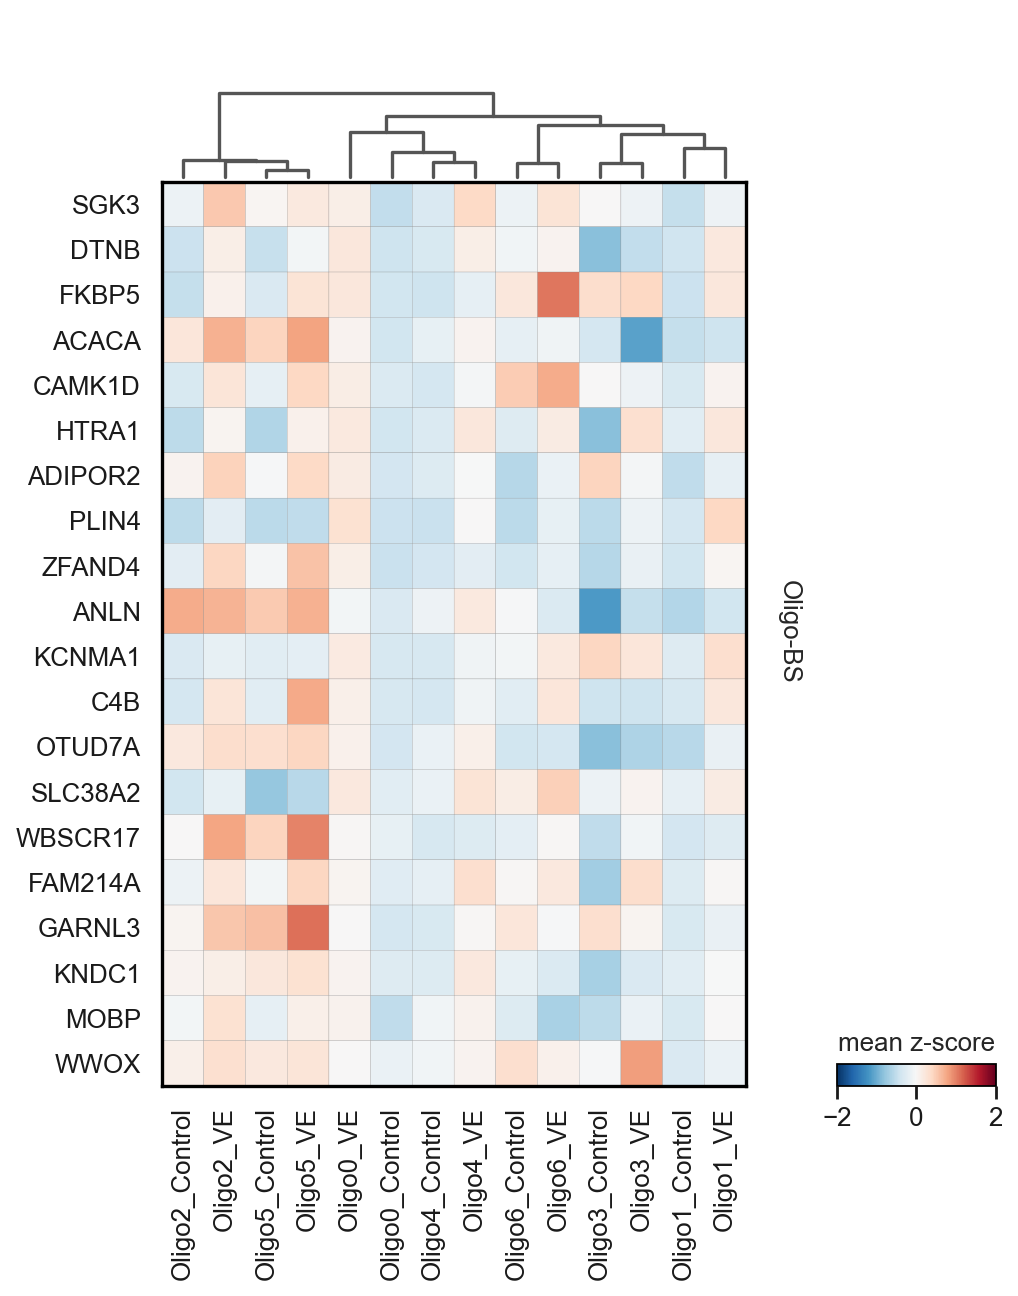

categories: Oligo0_Control, Oligo0_VE, Oligo1_Control, etc.
var_group_labels: Oligo-BS


/Users/fragkogs/miniconda3/envs/std/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


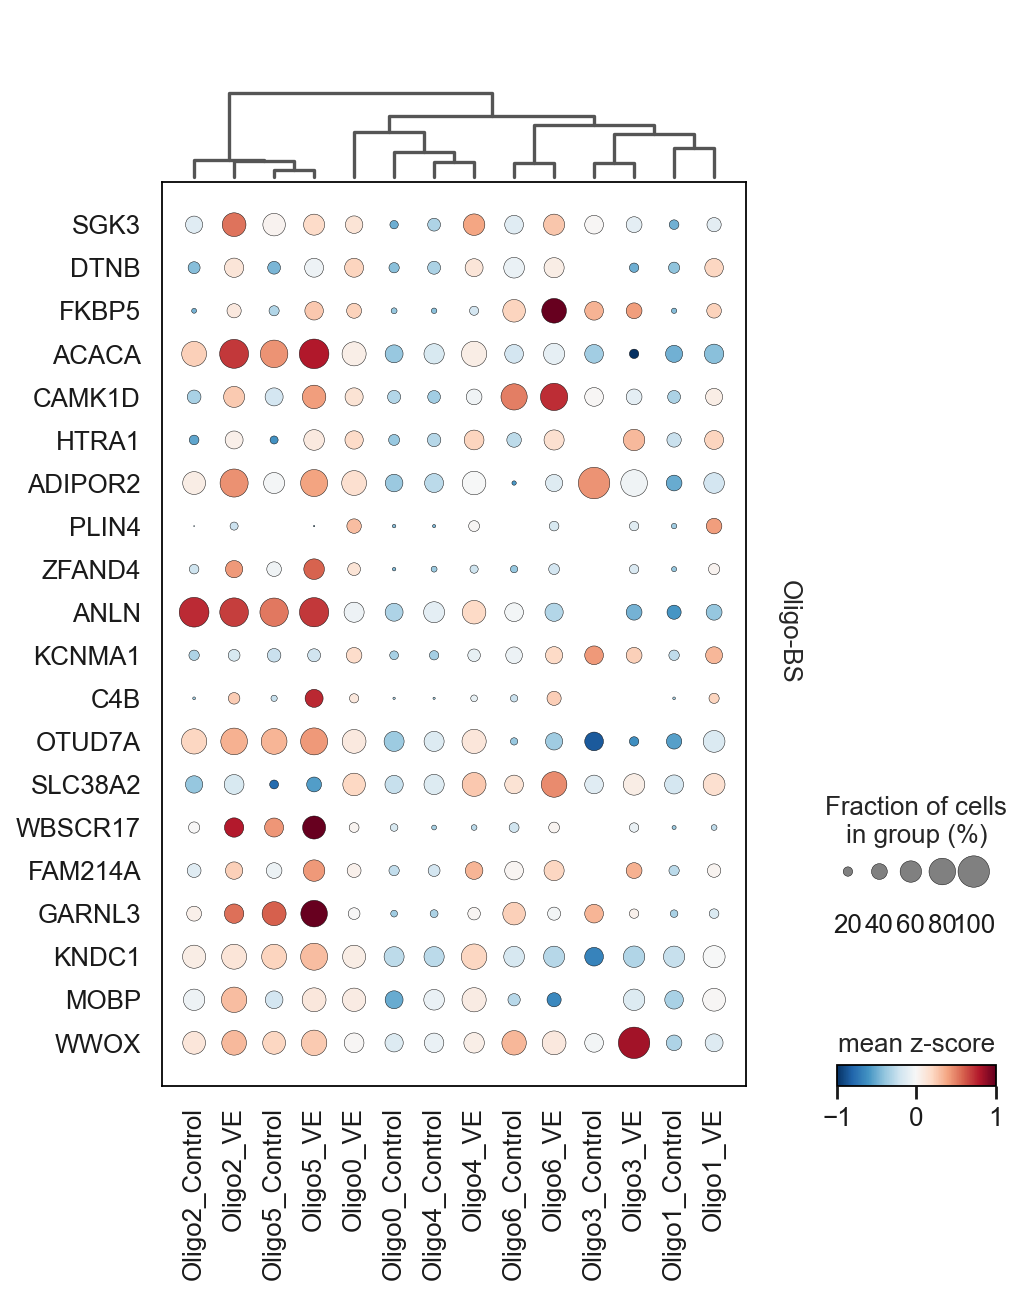

/Users/fragkogs/miniconda3/envs/std/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


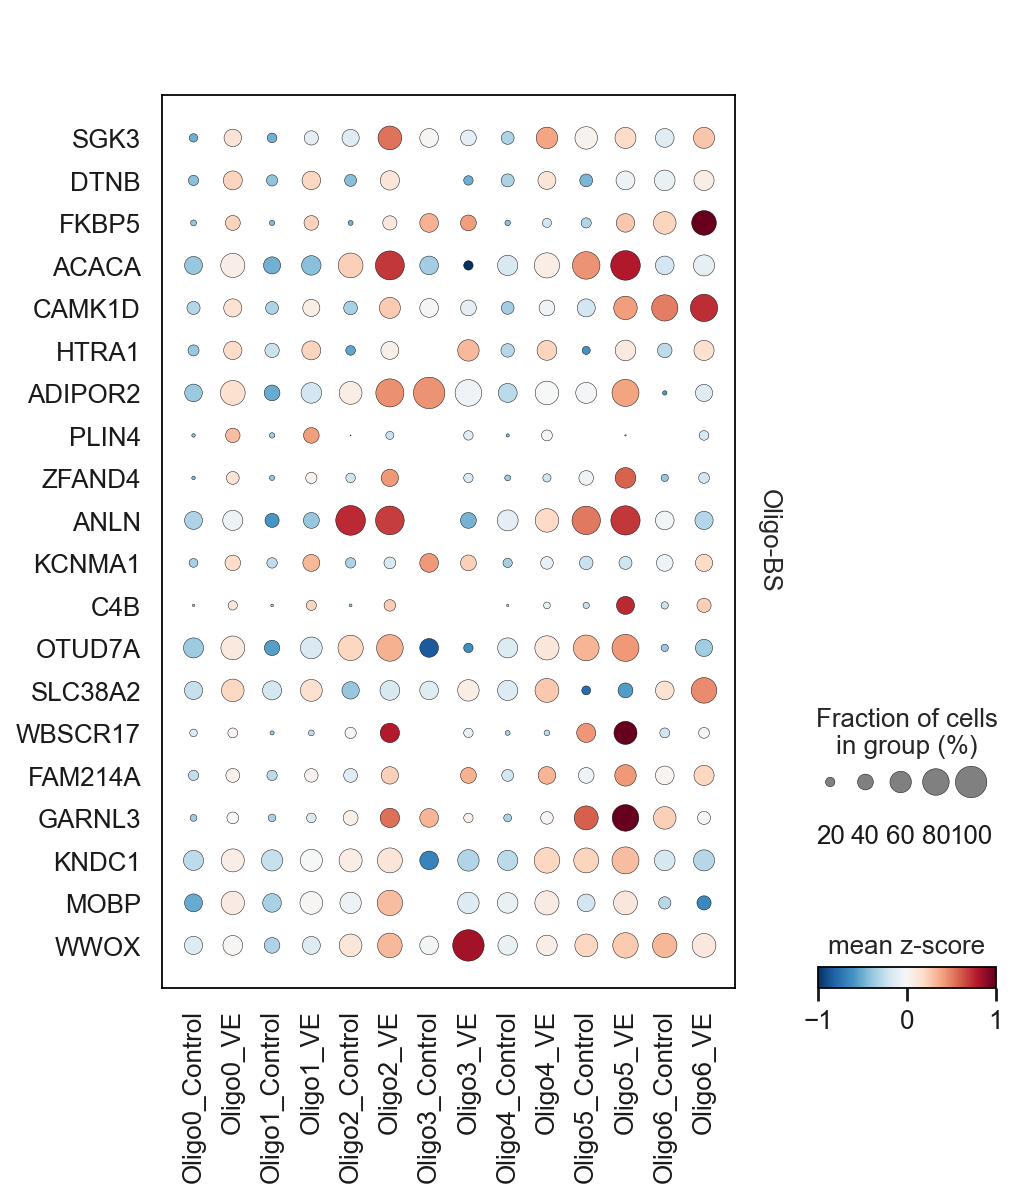

In [45]:
adata_oligo_BS.layers['scaled'] = sc.pp.scale(adata_oligo_BS, copy=True).X
sc.pl.matrixplot(adata_oligo_BS, marker_genes_dict, groupby=['PhenoGraph_clusters_oligo_str','Condition'], dendrogram=True,
                 colorbar_title='mean z-score', layer='scaled', vmin=-2, vmax=2, cmap='RdBu_r',swap_axes=True)

sc.pl.dotplot(adata_oligo_BS, marker_genes_dict, groupby=['PhenoGraph_clusters_oligo_str','Condition'], dendrogram=True,
             colorbar_title='mean z-score', layer='scaled', vmin=-1, vmax=1, cmap='RdBu_r',swap_axes=True)

sc.pl.dotplot(adata_oligo_BS, marker_genes_dict, groupby=['PhenoGraph_clusters_oligo_str','Condition'], dendrogram=False,
             colorbar_title='mean z-score', layer='scaled', vmin=-1, vmax=1, cmap='RdBu_r',swap_axes=True)

### Only VE

categories: Oligo0, Oligo1, Oligo2, etc.
var_group_labels: Oligo-BS


/Users/fragkogs/miniconda3/envs/std/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


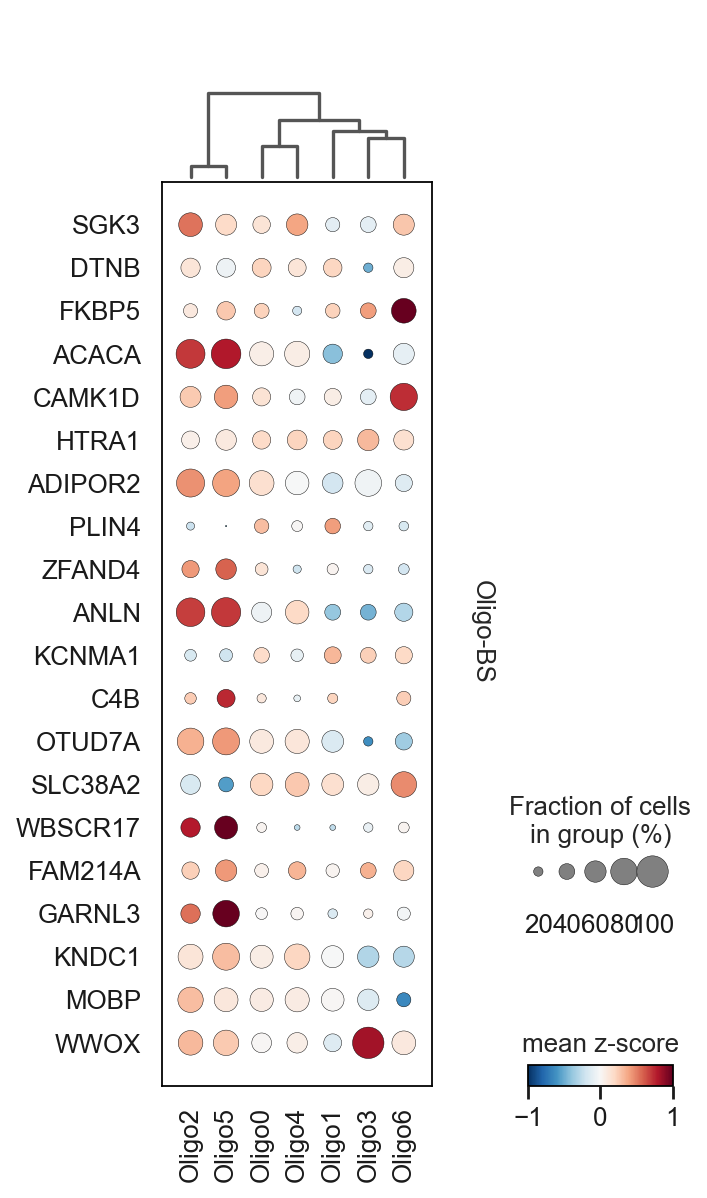

/Users/fragkogs/miniconda3/envs/std/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/fragkogs/miniconda3/envs/std/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


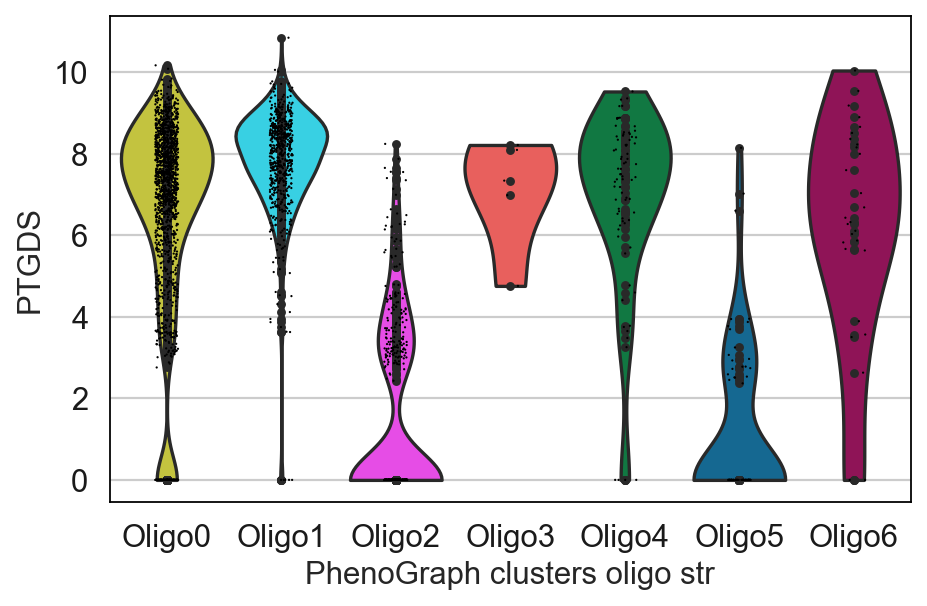

In [48]:
sc.pl.dotplot(adata_oligo_BS_VE, marker_genes_dict, groupby=['PhenoGraph_clusters_oligo_str'], dendrogram=True,
             colorbar_title='mean z-score', layer='scaled', vmin=-1, vmax=1, cmap='RdBu_r',swap_axes=True)
sc.pl.violin(adata_oligo_BS_VE, ['PTGDS'], groupby='PhenoGraph_clusters_oligo_str', inner='point', palette = godsnot_64)
#"#d9d929", "#1CE6FF", "#FF34FF", "#FF4A46"